# Прогнозирование температуры стального сплава

Чтобы оптимизировать производственные расходы, металлургический комбинат решил уменьшить потребление электроэнергии на этапе обработки стали. Для этого комбинату нужно контролировать температуру сплава. Ваша задача — построить модель, которая будет её предсказывать. Заказчик хочет использовать разработанную модель для имитации технологического процесса. Изучите его, прежде чем генерировать новые признаки.

Требуется построить модель, которая будет предсказывать температуру сплава. Это необходимо, чтобы оптимизировать производственные расходы на металлургическом комбинате, уменьшив потребление электроэнергии на этапе обработки стали, а для этого комбинату нужно контролировать температуру сплава. Заказчик хочет использовать разработанную модель для имитации технологического процесса.

**Описание процесса обработки**

Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены на крышке ковша.

Сначала происходит десульфурация — из стали выводят серу и корректируют её химический состав добавлением примесей. Затем сталь легируют — добавляют в неё куски сплава из бункера для сыпучих материалов или порошковую проволоку через специальный трайб-аппарат.

Прежде чем в первый раз ввести легирующие добавки, специалисты производят химический анализ стали и измеряют её температуру. Потом температуру на несколько минут повышают, уже после этого добавляют легирующие материалы и продувают сталь инертным газом, чтобы перемешать, а затем снова проводят измерения. Такой цикл повторяется до тех пор, пока не будут достигнуты нужный химический состав стали и оптимальная температура плавки.

Дальше расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (англ. slab, «плита»).

**Описание данных**

Данные хранятся в базе данных PostgreSQL. Она состоит из нескольких таблиц:
- `steel.data_arc` — данные об электродах;
- `steel.data_bulk` — данные об объёме сыпучих материалов;
- `steel.data_bulk_time` — данные о времени подачи сыпучих материалов;
- `steel.data_gas` — данные о продувке сплава газом;
- `steel.data_temp` — данные об измерениях температуры;
- `steel.data_wire` — данные об объёме проволочных материалов;
- `steel.data_wire_time` — данные о времени подачи проволочных материалов.

**Таблица `steel.data_arc`**
- `key` — номер партии;
- `BeginHeat` — время начала нагрева;
- `EndHeat` — время окончания нагрева;
- `ActivePower` — значение активной мощности;
- `ReactivePower` — значение реактивной мощности.

**Таблица `steel.data_bulk`**
- `key` — номер партии;
- `Bulk1` … `Bulk15` — объём подаваемого материала.

**Таблица `steel.data_bulk_time`**
- `key` — номер партии;
- `Bulk1` … `Bulk15` — время подачи материала.

**Таблица `steel.data_gas`**
- `key` — номер партии;
- `gas` — объём подаваемого газа.

**Таблица `steel.data_temp`**
- `key` — номер партии;
- `MesaureTime` — время замера;
- `Temperature` — значение температуры.

**Таблица `steel.data_wire`**
- `key` — номер партии;
- `Wire1` … `Wire15` — объём подаваемых проволочных материалов.

**Таблица `steel.data_wire_time`**
- `key` — номер партии;
- `Wire1` … `Wire15` — время подачи проволочных материалов.

Во всех файлах столбец `key` содержит номер партии. В таблицах может быть несколько строк с одинаковым значением `key`: они соответствуют разным итерациям обработки.

## Загрузка данных

Загрузим необходимые библиотеки и инструменты. Зададим константу RANDOM_STATE.

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (15,10)
import seaborn as sns

import datetime
from datetime import timedelta

import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader, TensorDataset

from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split, RandomizedSearchCV, KFold
from sklearn.preprocessing import StandardScaler

from sqlalchemy import create_engine

from tqdm import tqdm

from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

import warnings
warnings.filterwarnings('ignore')

RANDOM_STATE = 111223

Подключимся к базе данных

In [2]:
db_config = {
'user': '_',# имя пользователя
'pwd': '_',# пароль
'host': '_',
'port': 6432,# порт подключения
'db': '_'# название базы данных,
}

connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    db_config['user'],
    db_config['pwd'],
    db_config['host'],
    db_config['port'],
    db_config['db'],
)

In [3]:
engine = create_engine(connection_string)

## Загрузка данных

Загрузим данные и преобразуем их в таблицы pandas DataFrame.

In [4]:
def create_dataframes(table_names, engine):
    dfs = {}
    for table_name in table_names:
        query = f"SELECT * FROM {table_name}"
        table_df = pd.read_sql_query(query, engine)
        table_key = table_name.split('.')[-1]
        dfs[table_key] = table_df
        globals()[table_key] = table_df
    return dfs

In [5]:
table_names = ['steel.data_arc', 'steel.data_bulk', 'steel.data_bulk_time', 'steel.data_gas', 'steel.data_temp', 'steel.data_wire', 'steel.data_wire_time']

dfs = create_dataframes(table_names, engine)

## Исследовательский анализ и предобработка данных

Исследуем и предобработаем таблицы по очереди, и где необходимо создадим новые признаки.

In [6]:
def info_data(name, data):
    print('*' * (len(name) + 8))
    print('Таблица', name)
    print('*' * (len(name) + 8))
    display(data.head())
    data.info()
    display(data.describe())
    print('Количество строк с пропусками:', data.isna().sum().max())
    print('Количество дубликатов:', data.duplicated().sum())
    print('_' * 75)

### Данные об электродах

In [7]:
info_data('`data_arc`', data_arc)

******************
Таблица `data_arc`
******************


,key,BeginHeat,EndHeat,ActivePower,ReactivePower
0,1,11:02:14,11:06:02,0.976059,0.687084
1,1,11:07:28,11:10:33,0.805607,0.520285
2,1,11:11:44,11:14:36,0.744363,0.498805
3,1,11:18:14,11:24:19,1.659363,1.062669
4,1,11:26:09,11:28:37,0.692755,0.414397


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   key            14876 non-null  int64  
 1   BeginHeat      14876 non-null  object 
 2   EndHeat        14876 non-null  object 
 3   ActivePower    14876 non-null  float64
 4   ReactivePower  14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


,key,ActivePower,ReactivePower
count,14876.000000,14876.000000,14876.000000
mean,1615.220422,0.670441,0.452592
std,934.571502,0.408159,5.878702
min,1.000000,0.030002,-715.504924
25%,806.000000,0.395297,0.290991
50%,1617.000000,0.555517,0.415962
75%,2429.000000,0.857034,0.637371
max,3241.000000,3.731596,2.676388


Количество строк с пропусками: 0
Количество дубликатов: 0
___________________________________________________________________________


Приведём название столбцов к стандарту PEP-8 и преобразуем столбцы со временем к типу `datetime`.

In [8]:
data_arc.columns=['key', 'begin_heat', 'end_heat', 'active_power', 'reactive_power']

In [9]:
data_arc['begin_heat'] = pd.to_datetime(data_arc['begin_heat'], format='%H:%M:%S')
data_arc['end_heat'] = pd.to_datetime(data_arc['end_heat'], format='%H:%M:%S')

In [10]:
data_arc['key'].nunique()

3214

In [11]:
data_arc['key'].count() / data_arc['key'].nunique()

4.628500311138768

In [12]:
data_arc.groupby('key')['key'].count().value_counts()

4     892
5     759
3     520
6     490
7     205
2     174
8      84
1      39
9      28
10      9
11      5
12      3
13      2
15      2
16      1
14      1
Name: key, dtype: int64

В таблице содержатся записи о 3214 партиях стали. Количество обработок одной партии составляет от 1 до 16 раз. Среднее количество обработок одной партии - 4,6 раза. 

Посмотрим записи с отрицательной реактивной мощностью.

In [13]:
data_arc.query('reactive_power <= 0')

,key,begin_heat,end_heat,active_power,reactive_power
9781,2116,1900-01-01 00:44:48,1900-01-01 00:46:37,0.495782,-715.504924


In [14]:
data_arc.query('index != 9781')[['active_power', 'reactive_power']].corr()

,active_power,reactive_power
active_power,1.000000,0.963182
reactive_power,0.963182,1.000000


In [15]:
(data_arc.query('index != 9781')['reactive_power'] / data_arc.query('index != 9781')['active_power']).mean().round(2)

0.75

В таблице одна запись с отрицательной реактивной мощностью. К тому же значение её очень большое. Поэтому делаем вывод, что это значение ошибочное. 

Корреляция между активной и реактивной мощностью очень высокая. Реактивная мощность составляет в среднем 0.75 от активной мощности. Поэтому заменим ошибочное значение, на рассчитанное по этим данным.

In [16]:
data_arc.loc[data_arc['reactive_power'] < 0, 'reactive_power'] = data_arc['active_power'] * 0.75

Посмотрим на гистограммы и диаграммы размаха для активной и реактивной мощности.

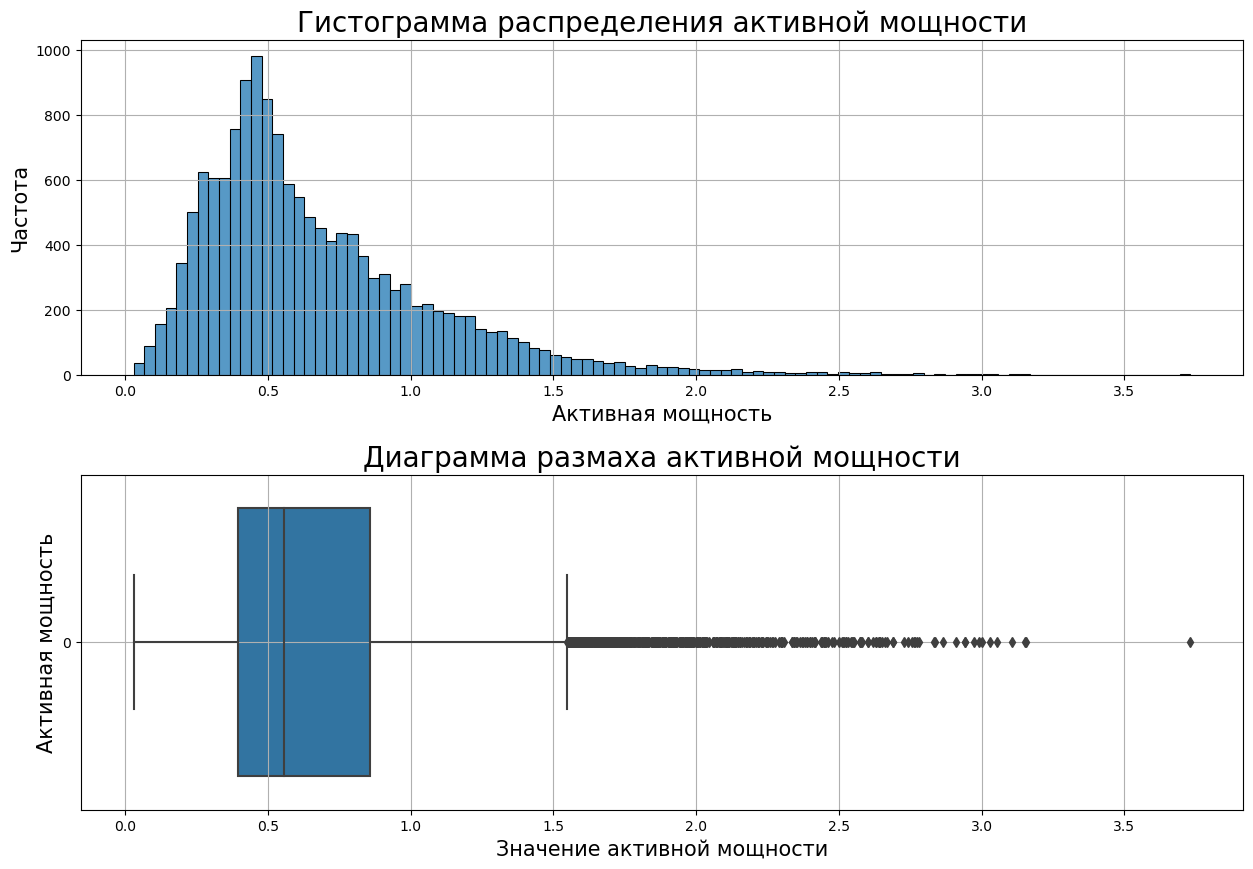

In [17]:
plt.figure()
plt.subplot(2,1,1)
sns.histplot(data=data_arc['active_power'])
plt.grid()
plt.xlabel('Активная мощность', fontsize=15)
plt.ylabel('Частота', fontsize=15)
plt.title('Гистограмма распределения активной мощности', fontsize=20)

plt.subplot(2,1,2)
sns.boxplot(data=data_arc['active_power'], orient='horizontal')
plt.grid()
plt.xlabel('Значение активной мощности', fontsize=15)
plt.ylabel('Активная мощность', fontsize=15)
plt.title('Диаграмма размаха активной мощности', fontsize=20)

plt.subplots_adjust(hspace=0.3)

plt.show();

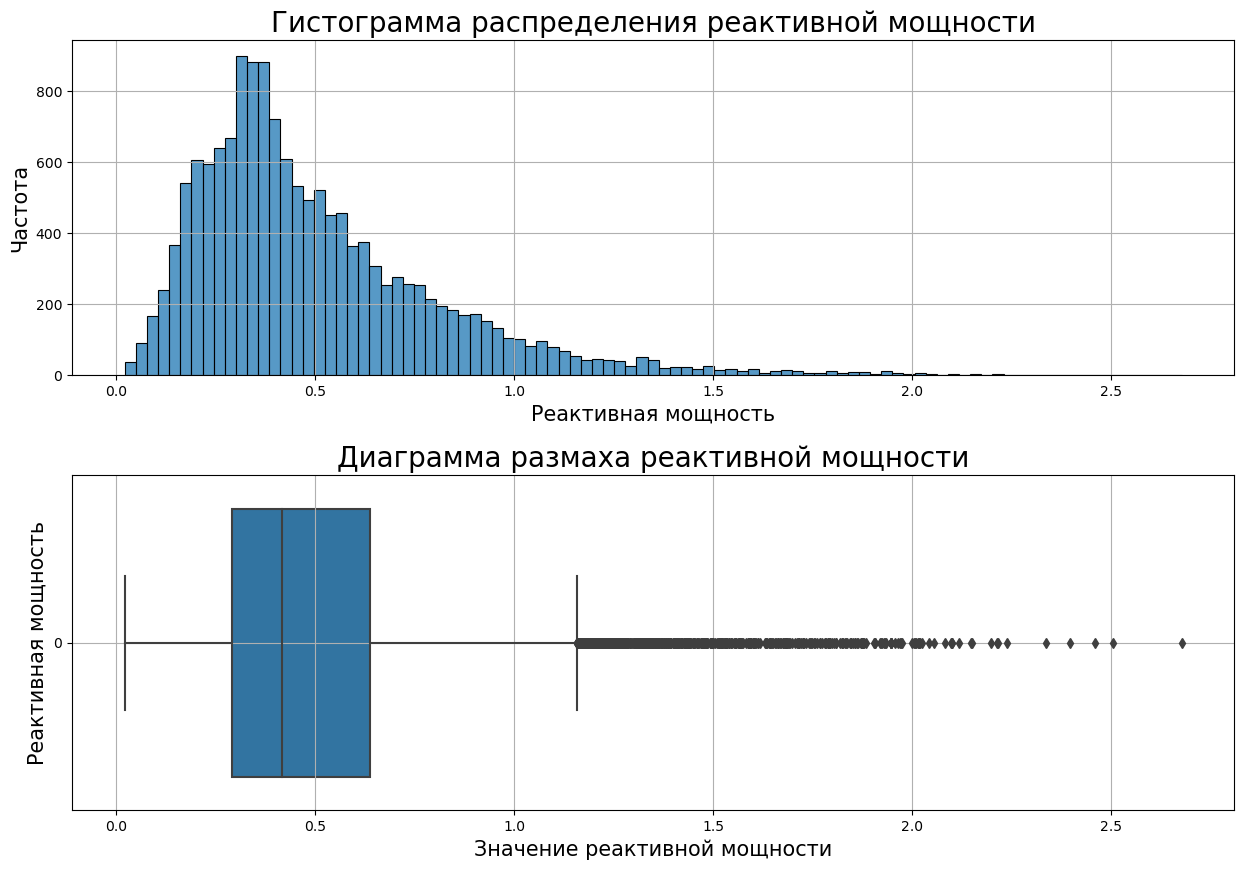

In [18]:
plt.figure()
plt.subplot(2,1,1)
sns.histplot(data=data_arc['reactive_power'])
plt.grid()
plt.xlabel('Реактивная мощность', fontsize=15)
plt.ylabel('Частота', fontsize=15)
plt.title('Гистограмма распределения реактивной мощности', fontsize=20)

plt.subplot(2,1,2)
sns.boxplot(data=data_arc['reactive_power'], orient='horizontal')
plt.grid()
plt.xlabel('Значение реактивной мощности', fontsize=15)
plt.ylabel('Реактивная мощность', fontsize=15)
plt.title('Диаграмма размаха реактивной мощности', fontsize=20)

plt.subplots_adjust(hspace=0.3)

plt.show();

Распределение выглядит нормальным, однако имеются выбросы, но явных аномалий не обнаружено.

Создадим новый признак `res` - разницу времени начала и конца нагрева электродов (в секундах).

In [19]:
data_arc['res'] = (data_arc['end_heat'] - data_arc['begin_heat']) // pd.Timedelta('1s')

In [20]:
data_arc['res'].describe()

count    14876.000000
mean        43.894663
std       3319.473237
min     -86330.000000
25%        106.750000
50%        147.000000
75%        214.000000
max        907.000000
Name: res, dtype: float64

In [21]:
data_arc.query('res <= 0')

,key,begin_heat,end_heat,active_power,reactive_power,res
580,126,1900-01-01 23:59:35,1900-01-01 00:01:55,0.527388,0.405463,-86260
1170,257,1900-01-01 23:58:57,1900-01-01 00:00:07,0.268811,0.175647,-86330
1280,280,1900-01-01 23:56:57,1900-01-01 00:01:43,1.197192,0.728587,-86114
1953,421,1900-01-01 23:58:33,1900-01-01 00:01:57,0.774585,0.583186,-86196
2952,642,1900-01-01 23:52:55,1900-01-01 00:03:13,2.415316,1.946081,-85782
3438,745,1900-01-01 23:58:27,1900-01-01 00:00:14,0.403792,0.281718,-86293
4250,913,1900-01-01 23:58:22,1900-01-01 00:01:34,0.787956,0.537366,-86208
4752,1026,1900-01-01 23:59:04,1900-01-01 00:07:07,1.680239,1.400063,-85917
5400,1175,1900-01-01 23:59:25,1900-01-01 00:05:07,1.325558,0.893414,-86058
6456,1404,1900-01-01 23:56:33,1900-01-01 00:01:05,1.217748,0.833978,-86128


У нас обнаружились результаты, имеющие высокие отрицательные значения. Можно сделать вывод, что конечное время нагрева зафиксировано на следующие сутки относительно начального времени. Поэтому прибавим 86400 секунд, что соответствует одним суткам, и получим корректные значения.

In [22]:
data_arc.loc[data_arc['res'] < 0, 'res'] = data_arc['res'] + 86400

Посмотрим на одном примере результат преобразования.

In [23]:
data_arc.query('index == 1170')

,key,begin_heat,end_heat,active_power,reactive_power,res
1170,257,1900-01-01 23:58:57,1900-01-01 00:00:07,0.268811,0.175647,70


In [24]:
data_arc['res'].describe()

count    14876.000000
mean       171.670946
std         98.186803
min         11.000000
25%        107.000000
50%        147.000000
75%        214.000000
max        907.000000
Name: res, dtype: float64

Добавим новый признак `total_power` - полная мощность, который рассчитывается по формуле $S = \sqrt{Q^2 + P^2}$, где $S$ - это полная мощность, $P$ - активная мощность, а $Q$ - реактивная мощность.

In [25]:
data_arc['total_power'] = np.sqrt(data_arc['active_power']**2 + data_arc['reactive_power']**2)

Добавим признак `power_factor` - коэффициент мощности, $Cosϕ = P/S$

In [26]:
data_arc['power_factor'] = data_arc['active_power'] / data_arc['total_power']

In [27]:
data_arc['energy'] = data_arc['res'] * data_arc['total_power']

In [28]:
data_arc.head()

,key,begin_heat,end_heat,active_power,reactive_power,res,total_power,power_factor,energy
0,1,1900-01-01 11:02:14,1900-01-01 11:06:02,0.976059,0.687084,228,1.193639,0.817717,272.149755
1,1,1900-01-01 11:07:28,1900-01-01 11:10:33,0.805607,0.520285,185,0.959010,0.840041,177.416785
2,1,1900-01-01 11:11:44,1900-01-01 11:14:36,0.744363,0.498805,172,0.896038,0.830728,154.118502
3,1,1900-01-01 11:18:14,1900-01-01 11:24:19,1.659363,1.062669,365,1.970470,0.842115,719.221394
4,1,1900-01-01 11:26:09,1900-01-01 11:28:37,0.692755,0.414397,148,0.807239,0.858178,119.471318


Агрегируем данные по ключу.

In [29]:
arc_agg_func = {
    'key'            : 'count', 
    'begin_heat'     : 'first',
    'end_heat'       : 'last',
    'active_power'   : 'mean',
    'reactive_power' : 'mean',
    'total_power'    : 'mean',
    'res'            : 'sum',
    'power_factor'   : 'mean',
    'energy'         : 'sum'
}

In [30]:
data_arc_group = data_arc.groupby('key').agg(arc_agg_func).rename(columns={'key':'key_counts'})
data_arc_group

,key_counts,begin_heat,end_heat,active_power,reactive_power,total_power,res,power_factor,energy
key,,,,,,,,,
1,5,1900-01-01 11:02:14,1900-01-01 11:28:37,0.975629,0.636648,1.165279,1098,0.837756,1442.377754
2,4,1900-01-01 11:34:14,1900-01-01 11:53:18,0.763150,0.499528,0.912304,811,0.840158,881.233565
3,5,1900-01-01 12:06:54,1900-01-01 12:32:19,0.505176,0.319815,0.597907,655,0.845421,525.066777
4,4,1900-01-01 12:39:37,1900-01-01 12:57:50,0.802313,0.515074,0.953741,741,0.841682,796.911309
5,4,1900-01-01 13:11:13,1900-01-01 13:33:55,0.836793,0.563161,1.008939,869,0.828104,1199.137958
...,...,...,...,...,...,...,...,...,...
3237,5,1900-01-01 22:41:18,1900-01-01 23:03:48,0.786493,0.565692,0.968996,909,0.809908,958.336236
3238,3,1900-01-01 23:26:18,1900-01-01 23:41:28,0.702176,0.560394,0.898847,546,0.781519,555.867370
3239,8,1900-01-01 01:26:53,1900-01-01 02:15:43,0.583344,0.388952,0.701485,1216,0.830510,1013.067719


### Данные об объёме сыпучих материалов

In [31]:
info_data('`data_bulk`', data_bulk)

*******************
Таблица `data_bulk`
*******************


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
count,3129.000000,252.000000,22.000000,1298.000000,1014.000000,77.000000,576.000000,25.000000,1.0,19.000000,176.000000,177.000000,2450.000000,18.000000,2806.000000,2248.000000
mean,1624.383509,39.242063,253.045455,113.879045,104.394477,107.025974,118.925347,305.600000,49.0,76.315789,83.284091,76.819209,260.471020,181.111111,170.284747,160.513345
std,933.337642,18.277654,21.180578,75.483494,48.184126,81.790646,72.057776,191.022904,NaN,21.720581,26.060347,59.655365,120.649269,46.088009,65.868652,51.765319
min,1.000000,10.000000,228.000000,6.000000,12.000000,11.000000,17.000000,47.000000,49.0,63.000000,24.000000,8.000000,53.000000,151.000000,16.000000,1.000000
25%,816.000000,27.000000,242.000000,58.000000,72.000000,70.000000,69.750000,155.000000,49.0,66.000000,64.000000,25.000000,204.000000,153.250000,119.000000,105.000000
50%,1622.000000,31.000000,251.500000,97.500000,102.000000,86.000000,100.000000,298.000000,49.0,68.000000,86.500000,64.000000,208.000000,155.500000,151.000000,160.000000
75%,2431.000000,46.000000,257.750000,152.000000,133.000000,132.000000,157.000000,406.000000,49.0,70.500000,102.000000,106.000000,316.000000,203.500000,205.750000,205.000000
max,3241.000000,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.0,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000


Количество строк с пропусками: 3128
Количество дубликатов: 0
___________________________________________________________________________


Приведём название столбцов к стандарту PEP-8.

In [32]:
data_bulk.columns = [x.replace(' ','_').lower() for x in  data_bulk.columns]

In [33]:
data_bulk.head()

,key,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0


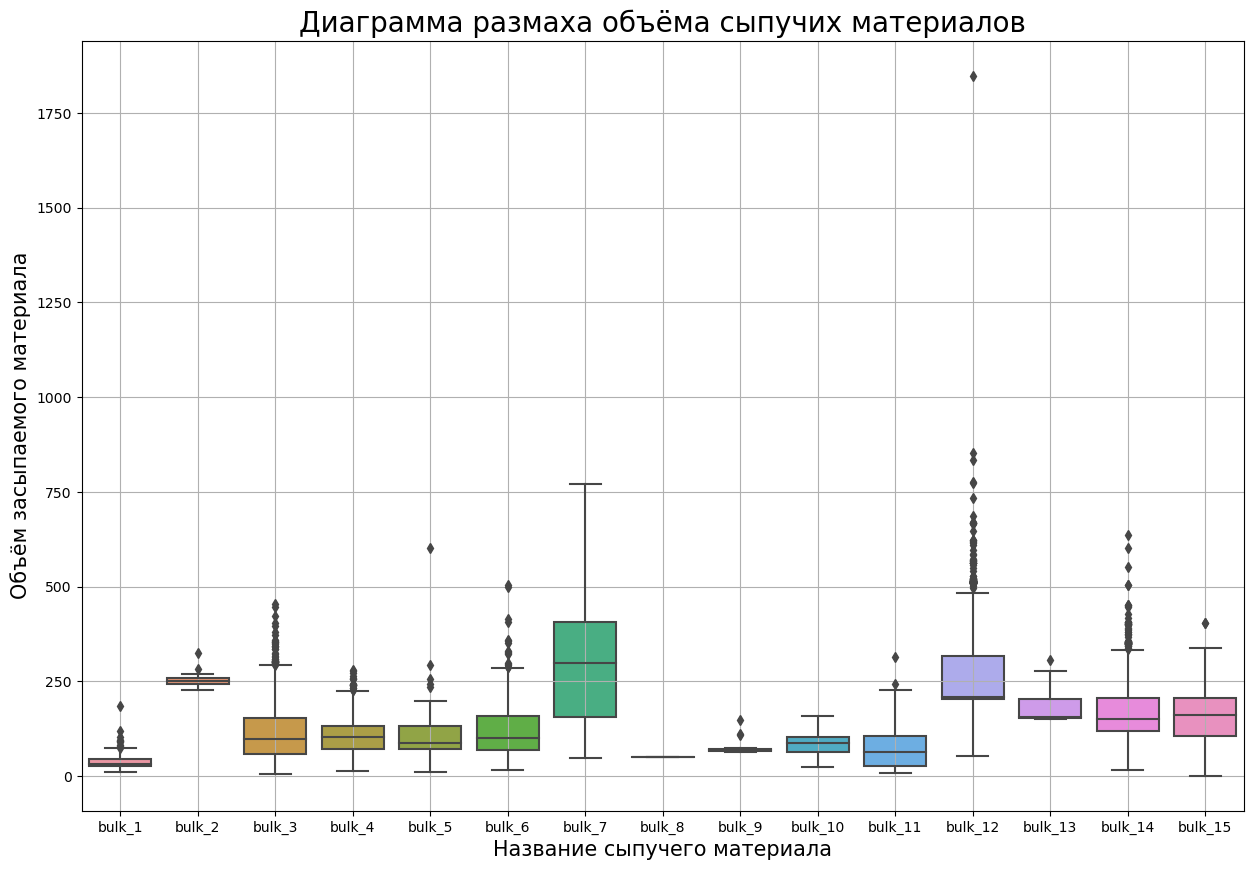

In [34]:
plt.figure()
sns.boxplot(data=data_bulk.iloc[:, 1:])
plt.grid()
plt.xlabel('Название сыпучего материала', fontsize=15)
plt.ylabel('Объём засыпаемого материала', fontsize=15)
plt.title('Диаграмма размаха объёма сыпучих материалов', fontsize=20)

plt.show();

Сыпучие материалы имеют нормальное распределение, за исключением единичного выброса материала `bulk_12`, который мы оставим, и единичного случая использования материала `bulk_8`, этот материал мы удалим из таблицы.

Значения NaN заменим нулевыми значениями, это означает, что данный материал не использовался в данной партии.

In [35]:
data_bulk = data_bulk.fillna(0)
data_bulk = data_bulk.drop('bulk_8', axis=1)
data_bulk.head()

,key,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15
0,1,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0
1,2,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0
2,3,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0
3,4,0.0,0.0,0.0,81.0,0.0,0.0,0.0,0.0,0.0,0.0,207.0,0.0,153.0,154.0
4,5,0.0,0.0,0.0,78.0,0.0,0.0,0.0,0.0,0.0,0.0,203.0,0.0,151.0,152.0


### Данные о времени подачи сыпучих материалов

In [36]:
info_data('`data_bulk_time`', data_bulk_time)

************************
Таблица `data_bulk_time`
************************


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,None,None,None,11:21:30,None,None,None,None,None,None,None,11:03:52,None,11:03:52,11:03:52
1,2,None,None,None,11:46:38,None,None,None,None,None,None,None,11:40:20,None,11:40:20,11:40:20
2,3,None,None,None,12:31:06,None,None,None,None,None,None,None,12:09:40,None,12:09:40,12:09:40
3,4,None,None,None,12:48:43,None,None,None,None,None,None,None,12:41:24,None,12:41:24,12:41:24
4,5,None,None,None,13:18:50,None,None,None,None,None,None,None,13:12:56,None,13:12:56,13:12:56


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB


,key
count,3129.000000
mean,1624.383509
std,933.337642
min,1.000000
25%,816.000000
50%,1622.000000
75%,2431.000000
max,3241.000000


Количество строк с пропусками: 3128
Количество дубликатов: 0
___________________________________________________________________________


Приведём название столбцов к стандарту PEP-8 и преобразуем столбцы со временем к типу `datetime`.

In [37]:
data_bulk_time.columns = [x.replace(' ','_').lower() for x in  data_bulk_time.columns]

In [38]:
for i in range(1,16):
    data_bulk_time['bulk_' + str(i)] = pd.to_datetime(data_bulk_time['bulk_' + str(i)], format='%H:%M:%S')

In [39]:
data_bulk_time.head()

,key,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15
0,1,NaT,NaT,NaT,1900-01-01 11:21:30,NaT,NaT,NaT,NaT,NaT,NaT,NaT,1900-01-01 11:03:52,NaT,1900-01-01 11:03:52,1900-01-01 11:03:52
1,2,NaT,NaT,NaT,1900-01-01 11:46:38,NaT,NaT,NaT,NaT,NaT,NaT,NaT,1900-01-01 11:40:20,NaT,1900-01-01 11:40:20,1900-01-01 11:40:20
2,3,NaT,NaT,NaT,1900-01-01 12:31:06,NaT,NaT,NaT,NaT,NaT,NaT,NaT,1900-01-01 12:09:40,NaT,1900-01-01 12:09:40,1900-01-01 12:09:40
3,4,NaT,NaT,NaT,1900-01-01 12:48:43,NaT,NaT,NaT,NaT,NaT,NaT,NaT,1900-01-01 12:41:24,NaT,1900-01-01 12:41:24,1900-01-01 12:41:24
4,5,NaT,NaT,NaT,1900-01-01 13:18:50,NaT,NaT,NaT,NaT,NaT,NaT,NaT,1900-01-01 13:12:56,NaT,1900-01-01 13:12:56,1900-01-01 13:12:56


In [40]:
data_bulk_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   key      3129 non-null   int64         
 1   bulk_1   252 non-null    datetime64[ns]
 2   bulk_2   22 non-null     datetime64[ns]
 3   bulk_3   1298 non-null   datetime64[ns]
 4   bulk_4   1014 non-null   datetime64[ns]
 5   bulk_5   77 non-null     datetime64[ns]
 6   bulk_6   576 non-null    datetime64[ns]
 7   bulk_7   25 non-null     datetime64[ns]
 8   bulk_8   1 non-null      datetime64[ns]
 9   bulk_9   19 non-null     datetime64[ns]
 10  bulk_10  176 non-null    datetime64[ns]
 11  bulk_11  177 non-null    datetime64[ns]
 12  bulk_12  2450 non-null   datetime64[ns]
 13  bulk_13  18 non-null     datetime64[ns]
 14  bulk_14  2806 non-null   datetime64[ns]
 15  bulk_15  2248 non-null   datetime64[ns]
dtypes: datetime64[ns](15), int64(1)
memory usage: 391.2 KB


Так как вкаждую партию стали добавляется несколько материалов, то нам надо вычислить время добавки первого материала и время добавки последнего материала, после этого можно вычислить длительность процесса. Добавим в таблицу соответствующие столбцы.

In [41]:
data_bulk_time['first_time_bulk'] = data_bulk_time.iloc[:, 1:].min(axis=1)
data_bulk_time['last_time_bulk'] = data_bulk_time.iloc[:, 1:].max(axis=1)
data_bulk_time['duration_bulk'] = (data_bulk_time['last_time_bulk'] - data_bulk_time['first_time_bulk']) // pd.Timedelta('1s')

In [42]:
data_bulk_time['duration_bulk'].describe()

count     3129.000000
mean      1156.364334
std       7059.208890
min          0.000000
25%        211.000000
50%        414.000000
75%        744.000000
max      86198.000000
Name: duration_bulk, dtype: float64

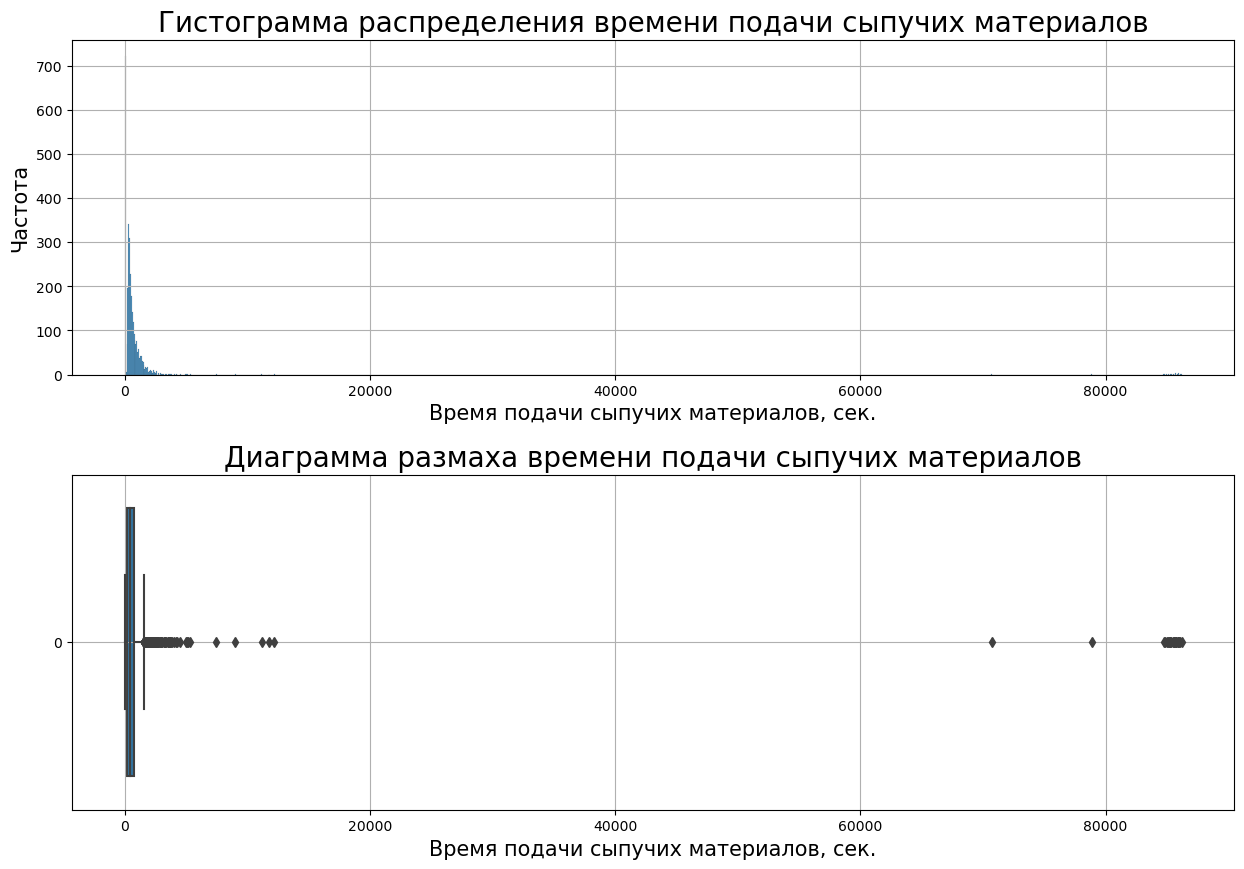

In [43]:
plt.figure()
plt.subplot(2,1,1)
sns.histplot(data=data_bulk_time['duration_bulk'])
plt.grid()
plt.xlabel('Время подачи сыпучих материалов, сек.', fontsize=15)
plt.ylabel('Частота', fontsize=15)
plt.title('Гистограмма распределения времени подачи сыпучих материалов', fontsize=20)

plt.subplot(2,1,2)
sns.boxplot(data=data_bulk_time['duration_bulk'], orient='horizontal')
plt.grid()
plt.xlabel('Время подачи сыпучих материалов, сек.', fontsize=15)
plt.title('Диаграмма размаха времени подачи сыпучих материалов', fontsize=20)

plt.subplots_adjust(hspace=0.3)

plt.show();

In [44]:
data_bulk_time.query('duration_bulk > 40000')

,key,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15,first_time_bulk,last_time_bulk,duration_bulk
41,44,NaT,NaT,NaT,NaT,NaT,1900-01-01 22:33:48,NaT,NaT,NaT,NaT,NaT,1900-01-01 00:39:35,1900-01-01 00:39:35,1900-01-01 22:15:42,1900-01-01 00:39:35,1900-01-01 00:39:35,1900-01-01 22:33:48,78853
64,74,NaT,NaT,NaT,1900-01-01 00:01:50,NaT,NaT,NaT,NaT,NaT,NaT,NaT,1900-01-01 23:53:27,NaT,1900-01-01 23:53:27,1900-01-01 23:53:27,1900-01-01 00:01:50,1900-01-01 23:53:27,85897
113,126,NaT,NaT,1900-01-01 00:00:01,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,1900-01-01 23:46:55,NaT,1900-01-01 23:46:55,1900-01-01 23:46:55,1900-01-01 00:00:01,1900-01-01 23:46:55,85614
216,232,NaT,NaT,NaT,NaT,1900-01-01 00:01:33,NaT,NaT,NaT,NaT,NaT,NaT,1900-01-01 23:50:13,NaT,1900-01-01 23:50:13,1900-01-01 23:50:13,1900-01-01 00:01:33,1900-01-01 23:50:13,85720
263,280,NaT,NaT,1900-01-01 23:51:46,NaT,NaT,NaT,NaT,NaT,1900-01-01 00:04:56,NaT,NaT,1900-01-01 23:23:23,NaT,1900-01-01 23:23:23,NaT,1900-01-01 00:04:56,1900-01-01 23:51:46,85610
614,641,NaT,NaT,NaT,1900-01-01 01:03:12,NaT,NaT,NaT,NaT,NaT,NaT,NaT,1900-01-01 20:42:03,1900-01-01 20:42:03,NaT,1900-01-01 20:42:03,1900-01-01 01:03:12,1900-01-01 20:42:03,70731
615,642,NaT,NaT,NaT,1900-01-01 00:22:47,NaT,NaT,NaT,NaT,NaT,NaT,NaT,1900-01-01 23:56:15,NaT,1900-01-01 23:56:15,1900-01-01 23:56:15,1900-01-01 00:22:47,1900-01-01 23:56:15,84808
880,913,NaT,NaT,1900-01-01 00:12:43,NaT,NaT,1900-01-01 00:12:43,NaT,NaT,NaT,NaT,NaT,1900-01-01 23:57:38,NaT,1900-01-01 23:57:38,NaT,1900-01-01 00:12:43,1900-01-01 23:57:38,85495
955,999,NaT,NaT,1900-01-01 00:04:29,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,1900-01-01 23:56:29,NaT,1900-01-01 23:56:29,1900-01-01 23:56:29,1900-01-01 00:04:29,1900-01-01 23:56:29,85920
1037,1082,NaT,NaT,NaT,1900-01-01 00:00:38,NaT,NaT,NaT,NaT,NaT,NaT,NaT,1900-01-01 23:39:05,NaT,1900-01-01 23:39:05,1900-01-01 23:39:05,1900-01-01 00:00:38,1900-01-01 23:39:05,85107


У нас обнаружились результаты, имеющие высокие значения. Можно сделать вывод, что конечное время добавки материалов зафиксировано на следующие сутки относительно начального времени. Поэтому напишем функцию, которая добавит одни сутки ко времени окончания добавки сыпучих материалов.

In [45]:
def increment_date(dataframe):
    mask = dataframe['duration_bulk'] > 40000
    time_columns = dataframe.columns[1:16]
    one_hour = timedelta(hours=1)
    one_day = timedelta(days=1)

    for column in time_columns:
        dataframe.loc[(mask) & (dataframe[column].dt.time < datetime.time(hour=2)), column] += one_day

    return dataframe

In [46]:
data_bulk_time = increment_date(data_bulk_time)

data_bulk_time.query('duration_bulk > 40000')

,key,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15,first_time_bulk,last_time_bulk,duration_bulk
41,44,NaT,NaT,NaT,NaT,NaT,1900-01-01 22:33:48,NaT,NaT,NaT,NaT,NaT,1900-01-02 00:39:35,1900-01-02 00:39:35,1900-01-01 22:15:42,1900-01-02 00:39:35,1900-01-01 00:39:35,1900-01-01 22:33:48,78853
64,74,NaT,NaT,NaT,1900-01-02 00:01:50,NaT,NaT,NaT,NaT,NaT,NaT,NaT,1900-01-01 23:53:27,NaT,1900-01-01 23:53:27,1900-01-01 23:53:27,1900-01-01 00:01:50,1900-01-01 23:53:27,85897
113,126,NaT,NaT,1900-01-02 00:00:01,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,1900-01-01 23:46:55,NaT,1900-01-01 23:46:55,1900-01-01 23:46:55,1900-01-01 00:00:01,1900-01-01 23:46:55,85614
216,232,NaT,NaT,NaT,NaT,1900-01-02 00:01:33,NaT,NaT,NaT,NaT,NaT,NaT,1900-01-01 23:50:13,NaT,1900-01-01 23:50:13,1900-01-01 23:50:13,1900-01-01 00:01:33,1900-01-01 23:50:13,85720
263,280,NaT,NaT,1900-01-01 23:51:46,NaT,NaT,NaT,NaT,NaT,1900-01-02 00:04:56,NaT,NaT,1900-01-01 23:23:23,NaT,1900-01-01 23:23:23,NaT,1900-01-01 00:04:56,1900-01-01 23:51:46,85610
614,641,NaT,NaT,NaT,1900-01-02 01:03:12,NaT,NaT,NaT,NaT,NaT,NaT,NaT,1900-01-01 20:42:03,1900-01-01 20:42:03,NaT,1900-01-01 20:42:03,1900-01-01 01:03:12,1900-01-01 20:42:03,70731
615,642,NaT,NaT,NaT,1900-01-02 00:22:47,NaT,NaT,NaT,NaT,NaT,NaT,NaT,1900-01-01 23:56:15,NaT,1900-01-01 23:56:15,1900-01-01 23:56:15,1900-01-01 00:22:47,1900-01-01 23:56:15,84808
880,913,NaT,NaT,1900-01-02 00:12:43,NaT,NaT,1900-01-02 00:12:43,NaT,NaT,NaT,NaT,NaT,1900-01-01 23:57:38,NaT,1900-01-01 23:57:38,NaT,1900-01-01 00:12:43,1900-01-01 23:57:38,85495
955,999,NaT,NaT,1900-01-02 00:04:29,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,1900-01-01 23:56:29,NaT,1900-01-01 23:56:29,1900-01-01 23:56:29,1900-01-01 00:04:29,1900-01-01 23:56:29,85920
1037,1082,NaT,NaT,NaT,1900-01-02 00:00:38,NaT,NaT,NaT,NaT,NaT,NaT,NaT,1900-01-01 23:39:05,NaT,1900-01-01 23:39:05,1900-01-01 23:39:05,1900-01-01 00:00:38,1900-01-01 23:39:05,85107


Чтобы корректно заполнить таблицу, заново заполним созданные ранее новые признаки корректными данными.

In [47]:
data_bulk_time['first_time_bulk'] = data_bulk_time.iloc[:, 1:16].min(axis=1)
data_bulk_time['last_time_bulk'] = data_bulk_time.iloc[:, 1:16].max(axis=1)
data_bulk_time['duration_bulk'] = (data_bulk_time['last_time_bulk'] - data_bulk_time['first_time_bulk']) // pd.Timedelta('1s')

In [48]:
data_bulk_time['duration_bulk'].describe()

count     3129.000000
mean       576.501438
std        769.158876
min          0.000000
25%        211.000000
50%        414.000000
75%        741.000000
max      15669.000000
Name: duration_bulk, dtype: float64

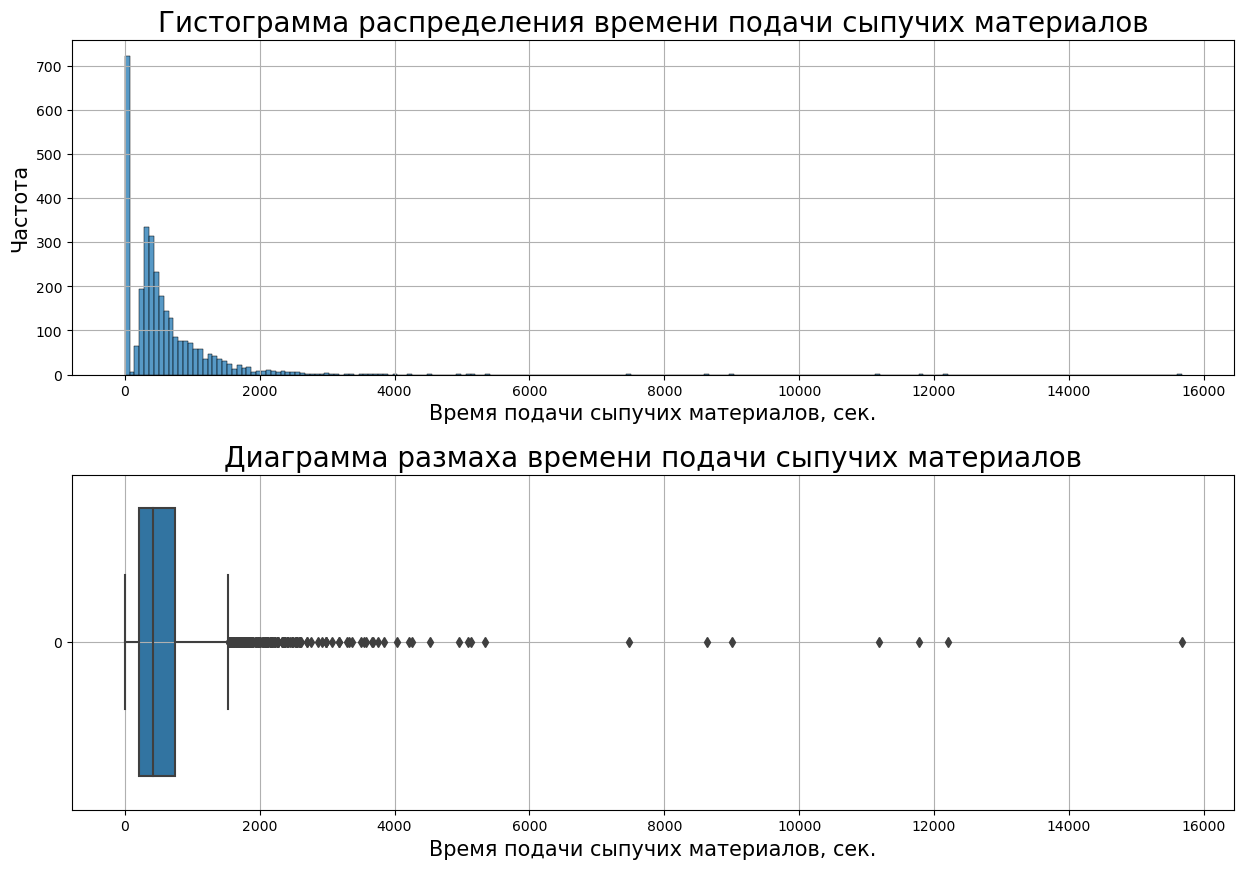

In [49]:
plt.figure()
plt.subplot(2,1,1)
sns.histplot(data=data_bulk_time['duration_bulk'])
plt.grid()
plt.xlabel('Время подачи сыпучих материалов, сек.', fontsize=15)
plt.ylabel('Частота', fontsize=15)
plt.title('Гистограмма распределения времени подачи сыпучих материалов', fontsize=20)

plt.subplot(2,1,2)
sns.boxplot(data=data_bulk_time['duration_bulk'], orient='horizontal')
plt.grid()
plt.xlabel('Время подачи сыпучих материалов, сек.', fontsize=15)
plt.title('Диаграмма размаха времени подачи сыпучих материалов', fontsize=20)

plt.subplots_adjust(hspace=0.3)

plt.show();

In [50]:
data_bulk_time.query('duration_bulk > 10000')

,key,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15,first_time_bulk,last_time_bulk,duration_bulk
614,641,NaT,NaT,NaT,1900-01-02 01:03:12,NaT,NaT,NaT,NaT,NaT,NaT,NaT,1900-01-01 20:42:03,1900-01-01 20:42:03,NaT,1900-01-01 20:42:03,1900-01-01 20:42:03,1900-01-02 01:03:12,15669
770,801,NaT,NaT,1900-01-01 04:45:29,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,1900-01-01 01:22:08,NaT,1900-01-01 01:22:08,1900-01-01 04:32:02,1900-01-01 01:22:08,1900-01-01 04:45:29,12201
1631,1689,NaT,NaT,NaT,NaT,NaT,1900-01-01 15:45:57,NaT,NaT,NaT,NaT,NaT,1900-01-01 15:33:13,1900-01-01 18:49:35,1900-01-01 15:33:13,1900-01-01 15:33:13,1900-01-01 15:33:13,1900-01-01 18:49:35,11782
1820,1881,NaT,NaT,1900-01-01 10:21:53,NaT,NaT,1900-01-01 07:21:47,NaT,NaT,NaT,NaT,1900-01-01 07:21:47,1900-01-01 07:15:23,NaT,1900-01-01 07:15:23,1900-01-01 07:15:23,1900-01-01 07:15:23,1900-01-01 10:21:53,11190


Несмотря на то, что в данных есть выбросы, аномалий не обнаружено.

Оставим в таблице только столбец с ключом и столбцы с новыми признаками.

In [51]:
data_bulk_time = data_bulk_time[['key', 'first_time_bulk', 'last_time_bulk','duration_bulk']]

In [52]:
data_bulk_time.head()

,key,first_time_bulk,last_time_bulk,duration_bulk
0,1,1900-01-01 11:03:52,1900-01-01 11:21:30,1058
1,2,1900-01-01 11:40:20,1900-01-01 11:46:38,378
2,3,1900-01-01 12:09:40,1900-01-01 12:31:06,1286
3,4,1900-01-01 12:41:24,1900-01-01 12:48:43,439
4,5,1900-01-01 13:12:56,1900-01-01 13:18:50,354


In [53]:
data_bulk_time.describe(include='all')

,key,first_time_bulk,last_time_bulk,duration_bulk
count,3129.000000,3129,3129,3129.000000
unique,NaN,3068,3075,NaN
top,NaN,1900-01-01 05:49:32,1900-01-01 08:24:12,NaN
freq,NaN,3,3,NaN
first,NaN,1900-01-01 00:00:11,1900-01-01 00:01:00,NaN
last,NaN,1900-01-01 23:58:54,1900-01-02 01:03:12,NaN
mean,1624.383509,NaN,NaN,576.501438
std,933.337642,NaN,NaN,769.158876
min,1.000000,NaN,NaN,0.000000
25%,816.000000,NaN,NaN,211.000000


### Данные о продувке сплава газом

In [54]:
info_data('`data_gas`', data_gas)

******************
Таблица `data_gas`
******************


,key,gas
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   gas     3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


,key,gas
count,3239.000000,3239.000000
mean,1621.861377,11.002062
std,935.386334,6.220327
min,1.000000,0.008399
25%,812.500000,7.043089
50%,1622.000000,9.836267
75%,2431.500000,13.769915
max,3241.000000,77.995040


Количество строк с пропусками: 0
Количество дубликатов: 0
___________________________________________________________________________


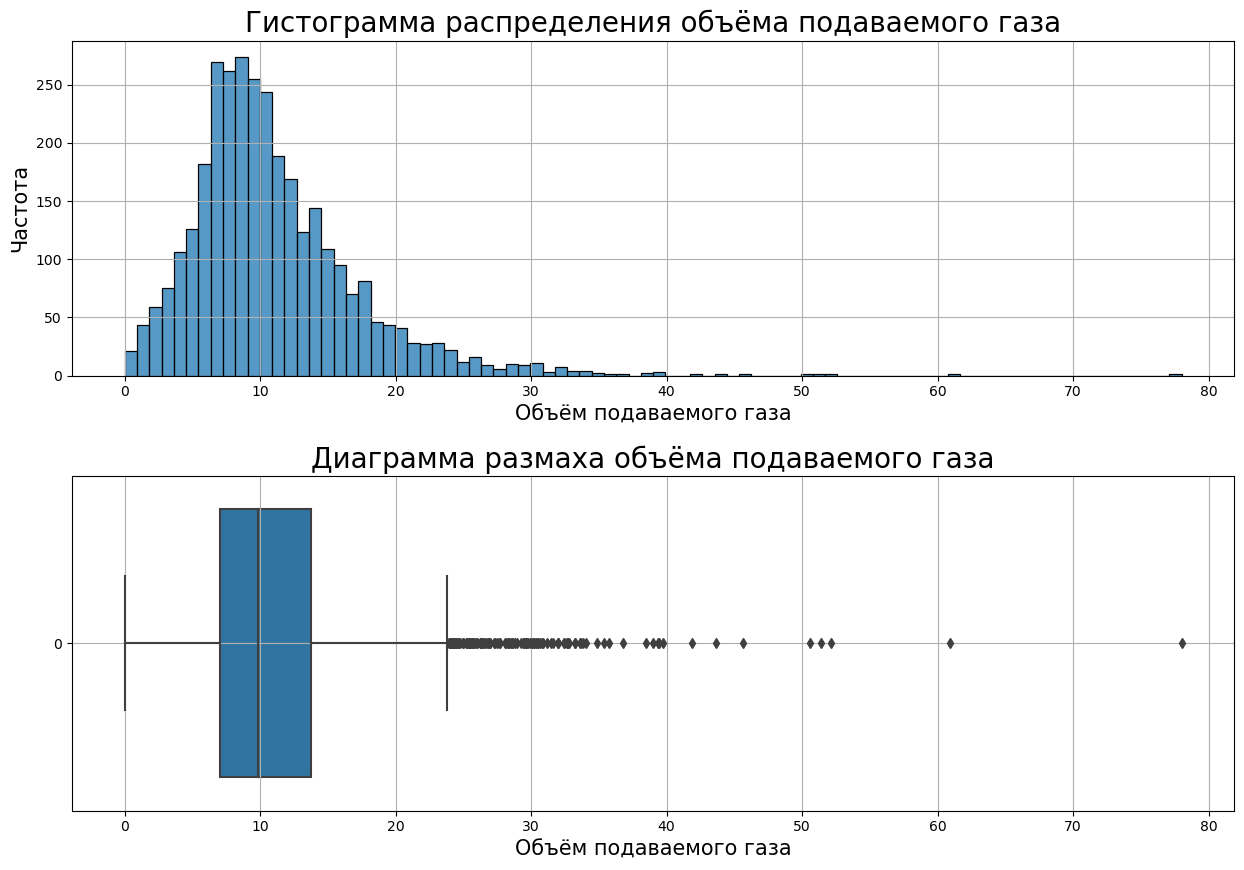

In [55]:
plt.figure()
plt.subplot(2,1,1)
sns.histplot(data=data_gas['gas'])
plt.grid()
plt.xlabel('Объём подаваемого газа', fontsize=15)
plt.ylabel('Частота', fontsize=15)
plt.title('Гистограмма распределения объёма подаваемого газа', fontsize=20)

plt.subplot(2,1,2)
sns.boxplot(data=data_gas['gas'], orient='horizontal')
plt.grid()
plt.xlabel('Объём подаваемого газа', fontsize=15)
plt.title('Диаграмма размаха объёма подаваемого газа', fontsize=20)

plt.subplots_adjust(hspace=0.3)

plt.show();

In [56]:
data_gas.query('gas > 50')

,key,gas
116,117,50.581035
277,280,60.935689
319,322,77.995040
2107,2110,52.142373
2567,2570,51.380229


Распределение в таблице выглядит нормальным, имеются выбросы, но явных аномалий не обнаружено.

### Данные об измерениях температуры

In [57]:
info_data('`data_temp`', data_temp)

*******************
Таблица `data_temp`
*******************


,key,MesaureTime,Temperature
0,1,11:16:18,1571.0
1,1,11:25:53,1604.0
2,1,11:29:11,1618.0
3,1,11:30:01,1601.0
4,1,11:30:39,1613.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   key          15907 non-null  int64  
 1   MesaureTime  15907 non-null  object 
 2   Temperature  13006 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 372.9+ KB


,key,Temperature
count,15907.000000,13006.000000
mean,1607.880870,1591.840920
std,942.212073,21.375851
min,1.000000,1191.000000
25%,790.000000,1581.000000
50%,1618.000000,1591.000000
75%,2427.000000,1601.000000
max,3241.000000,1705.000000


Количество строк с пропусками: 2901
Количество дубликатов: 0
___________________________________________________________________________


Приведём название столбцов к стандарту PEP-8 и преобразуем столбцы со временем к типу `datetime`.

In [58]:
data_temp.columns=['key', 'mesaure_time', 'temperature']

In [59]:
data_temp['mesaure_time'] = pd.to_datetime(data_temp['mesaure_time'], format='%H:%M:%S')

In [60]:
data_temp.head()

,key,mesaure_time,temperature
0,1,1900-01-01 11:16:18,1571.0
1,1,1900-01-01 11:25:53,1604.0
2,1,1900-01-01 11:29:11,1618.0
3,1,1900-01-01 11:30:01,1601.0
4,1,1900-01-01 11:30:39,1613.0


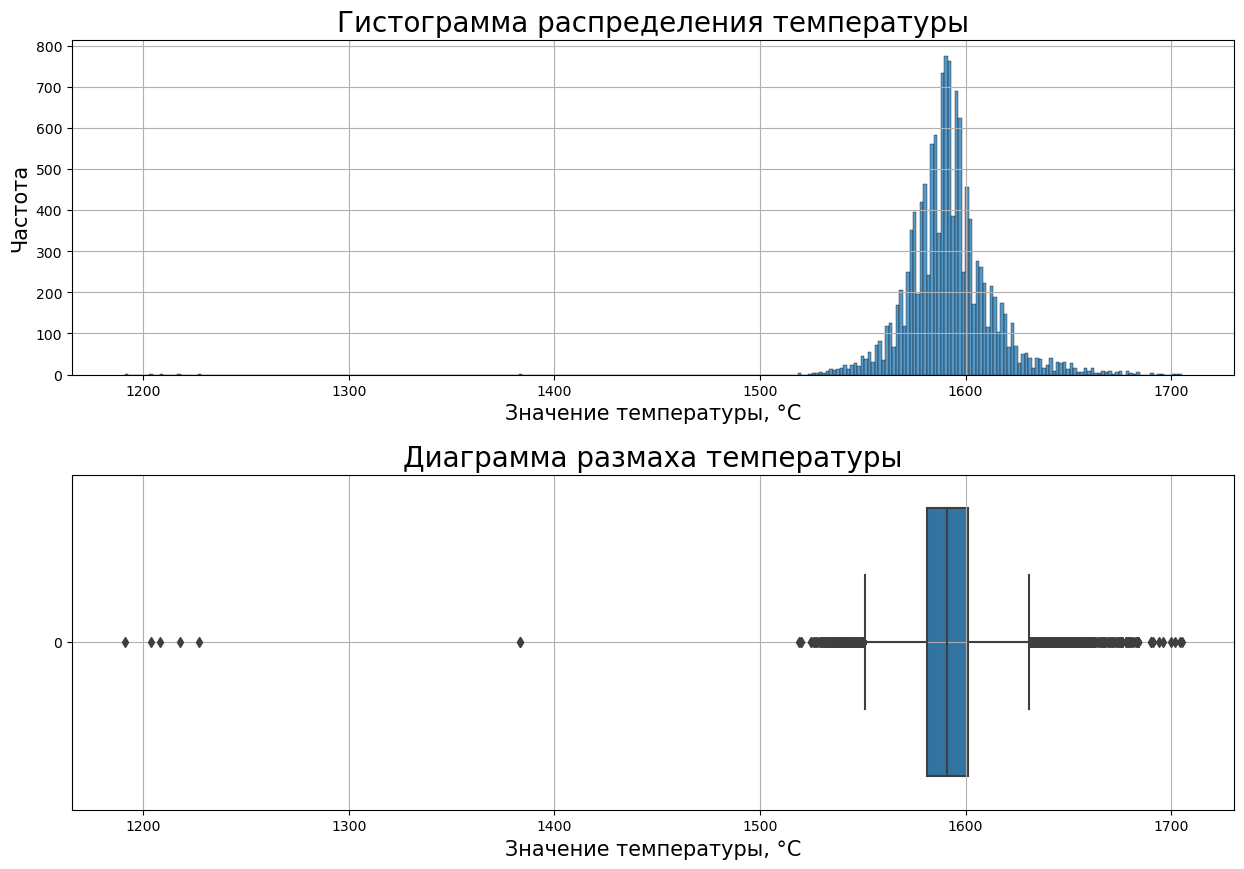

In [61]:
plt.figure()
plt.subplot(2,1,1)
sns.histplot(data=data_temp['temperature'])
plt.grid()
plt.xlabel('Значение температуры, °С', fontsize=15)
plt.ylabel('Частота', fontsize=15)
plt.title('Гистограмма распределения температуры', fontsize=20)

plt.subplot(2,1,2)
sns.boxplot(data=data_temp['temperature'], orient='horizontal')
plt.grid()
plt.xlabel('Значение температуры, °С', fontsize=15)
plt.title('Диаграмма размаха температуры', fontsize=20)

plt.subplots_adjust(hspace=0.3)

plt.show();

Удалим все записи с промежуточными замерами температуры для каждой партии, оставим только данные первого и последнего замера температуры.

In [62]:
#data_temp.groupby('key')['key'].count().value_counts()

In [63]:
data_temp_key = data_temp[data_temp['temperature'].isna()]['key'].unique()
data_temp = data_temp[~data_temp['key'].isin(data_temp_key)]
data_temp.head()

,key,mesaure_time,temperature
0,1,1900-01-01 11:16:18,1571.0
1,1,1900-01-01 11:25:53,1604.0
2,1,1900-01-01 11:29:11,1618.0
3,1,1900-01-01 11:30:01,1601.0
4,1,1900-01-01 11:30:39,1613.0


In [64]:
data_temp.shape

(12267, 3)

In [65]:
import pandas as pd

def temp_first_last(data):
    data_temp_sorted = pd.DataFrame()
    for key in data['key'].unique():
        sorted_data = data[data['key'] == key].sort_values(by='mesaure_time')
        if len(sorted_data) > 1:
            data_temp_sorted = data_temp_sorted.append(sorted_data.head(1))
            data_temp_sorted = data_temp_sorted.append(sorted_data.tail(1))
    return data_temp_sorted

data_temp = temp_first_last(data_temp)
data_temp.head()

,key,mesaure_time,temperature
0,1,1900-01-01 11:16:18,1571.0
4,1,1900-01-01 11:30:39,1613.0
5,2,1900-01-01 11:37:27,1581.0
10,2,1900-01-01 11:59:12,1602.0
11,3,1900-01-01 12:13:17,1596.0


In [66]:
data_temp.shape

(4950, 3)

Заказчик предупредил, что записи со значением температуры меньше 1500 градусов являются аномальными. Эти записи мы удалим.

In [67]:
temp_min = data_temp[data_temp['temperature'] <= 1500]['key'].unique()
data_temp = data_temp[~data_temp['key'].isin(temp_min)]

In [68]:
data_temp.shape

(4942, 3)

In [69]:
data_temp.describe()

,key,temperature
count,4942.000000,4942.000000
mean,1250.484015,1592.049575
std,720.036613,21.234101
min,1.000000,1519.000000
25%,628.250000,1581.000000
50%,1252.000000,1591.000000
75%,1872.750000,1601.000000
max,2499.000000,1700.000000


Создадим новые признаки - столбцы с начальной и конечной температурой, а также столбец с временем между замерами температуры.

In [70]:
def duration_temp(data):
    list = []
    
    for key in data['key'].unique():
        tmp = data[data['key']==key].reset_index(drop=True)
        start = tmp.loc[0,'temperature']
        finish = tmp.loc[1,'temperature']
        delta = (tmp.loc[1,'mesaure_time'] - tmp.loc[0,'mesaure_time']).seconds

        list.append([key, start, finish, delta])
    
    return pd.DataFrame(list,
                        columns=['key',
                                 'start_temperature',
                                 'finish_temperature',
                                 'duration_time'])

data_temp = duration_temp(data_temp)
data_temp.head()

,key,start_temperature,finish_temperature,duration_time
0,1,1571.0,1613.0,861
1,2,1581.0,1602.0,1305
2,3,1596.0,1599.0,1300
3,4,1601.0,1625.0,388
4,5,1576.0,1602.0,762


In [71]:
data_temp.shape

(2471, 4)

### Данные об объёме проволочных материалов

In [72]:
info_data('`data_wire`', data_wire)

*******************
Таблица `data_wire`
*******************


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
count,3081.000000,3055.000000,1079.000000,63.000000,14.000000,1.000,73.000000,11.000000,19.000000,29.000000
mean,1623.426485,100.895853,50.577323,189.482681,57.442841,15.132,48.016974,10.039007,53.625193,34.155752
std,932.996726,42.012518,39.320216,99.513444,28.824667,NaN,33.919845,8.610584,16.881728,19.931616
min,1.000000,1.918800,0.030160,0.144144,24.148801,15.132,0.034320,0.234208,45.076721,4.622800
25%,823.000000,72.115684,20.193680,95.135044,40.807002,15.132,25.053600,6.762756,46.094879,22.058401
50%,1619.000000,100.158234,40.142956,235.194977,45.234282,15.132,42.076324,9.017009,46.279999,30.066399
75%,2434.000000,126.060484,70.227558,276.252014,76.124619,15.132,64.212723,11.886057,48.089603,43.862003
max,3241.000000,330.314424,282.780152,385.008668,113.231044,15.132,180.454575,32.847674,102.762401,90.053604


Количество строк с пропусками: 3080
Количество дубликатов: 0
___________________________________________________________________________


Приведём название столбцов к стандарту PEP-8.

In [73]:
data_wire.columns = [x.replace(' ','_').lower() for x in  data_wire.columns]

In [74]:
data_wire.head()

,key,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN


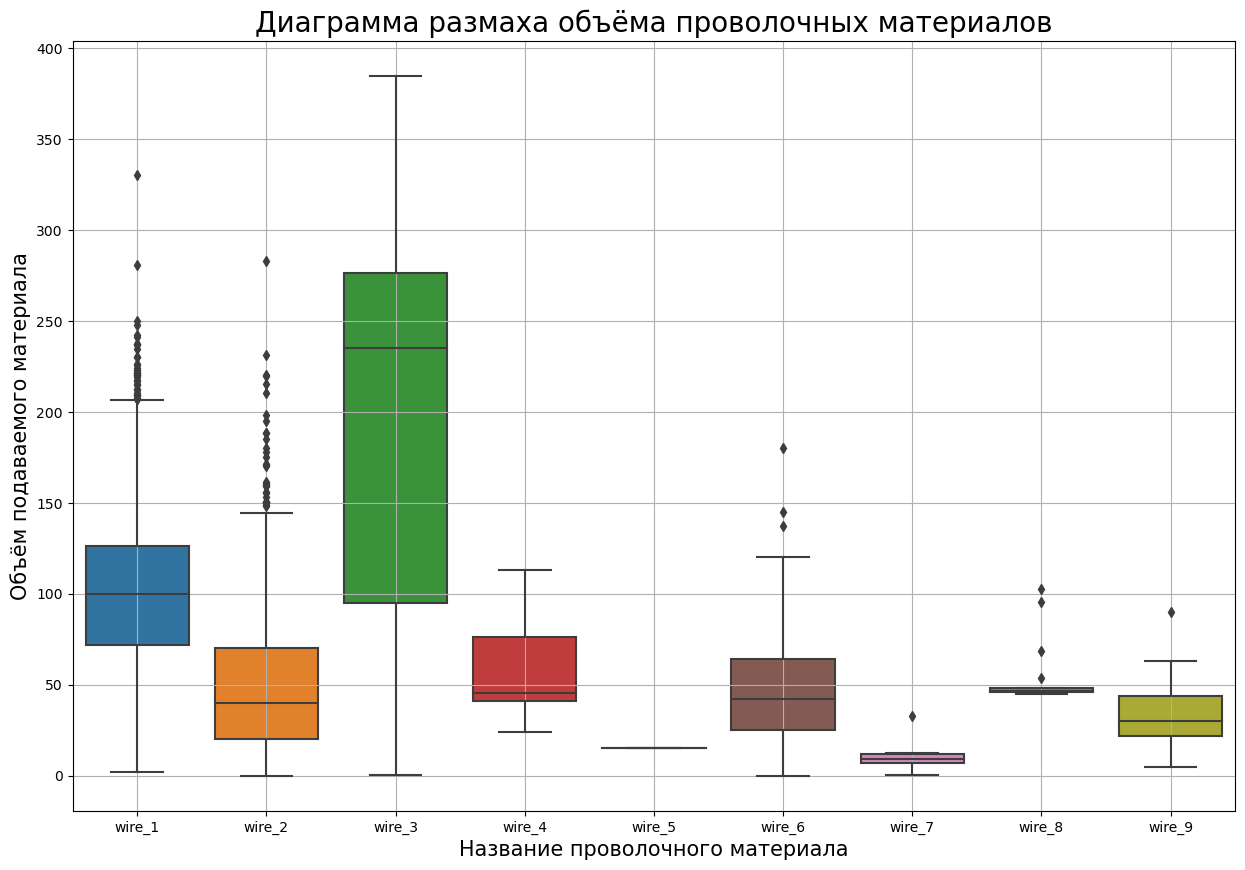

In [75]:
plt.figure()
sns.boxplot(data=data_wire.iloc[:, 1:])
plt.grid()
plt.xlabel('Название проволочного материала', fontsize=15)
plt.ylabel('Объём подаваемого материала', fontsize=15)
plt.title('Диаграмма размаха объёма проволочных материалов', fontsize=20)

plt.show();

Проволочные материалы имеют нормальное распределение, за исключением единичного случая использования материала `wire_5`, этот материал мы удалим из таблицы.

Значения NaN заменим нулевыми значениями, это означает, что данный материал не использовался в данной партии.

In [76]:
data_wire = data_wire.fillna(0)
data_wire = data_wire.drop('wire_5', axis=1)
data_wire.head()

,key,wire_1,wire_2,wire_3,wire_4,wire_6,wire_7,wire_8,wire_9
0,1,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
1,2,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
2,3,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
3,4,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
4,5,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0


### Данные о времени подачи проволочных материалов

In [77]:
info_data('`data_wire_time`', data_wire_time)

************************
Таблица `data_wire_time`
************************


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,11:11:41,None,None,None,None,None,None,None,None
1,2,11:46:10,None,None,None,None,None,None,None,None
2,3,12:13:47,None,None,None,None,None,None,None,None
3,4,12:48:05,None,None,None,None,None,None,None,None
4,5,13:18:15,13:32:06,None,None,None,None,None,None,None


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


,key
count,3081.000000
mean,1623.426485
std,932.996726
min,1.000000
25%,823.000000
50%,1619.000000
75%,2434.000000
max,3241.000000


Количество строк с пропусками: 3080
Количество дубликатов: 0
___________________________________________________________________________


Приведём название столбцов к стандарту PEP-8 и преобразуем столбцы со временем к типу `datetime`.

In [78]:
data_wire_time.columns = [x.replace(' ','_').lower() for x in  data_wire_time.columns]

In [79]:
for i in range(1,10):
    data_wire_time['wire_' + str(i)] = pd.to_datetime(data_wire_time['wire_' + str(i)], format='%H:%M:%S')

In [80]:
data_wire_time.head()

,key,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
0,1,1900-01-01 11:11:41,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
1,2,1900-01-01 11:46:10,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
2,3,1900-01-01 12:13:47,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
3,4,1900-01-01 12:48:05,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
4,5,1900-01-01 13:18:15,1900-01-01 13:32:06,NaT,NaT,NaT,NaT,NaT,NaT,NaT


In [81]:
data_wire_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   key     3081 non-null   int64         
 1   wire_1  3055 non-null   datetime64[ns]
 2   wire_2  1079 non-null   datetime64[ns]
 3   wire_3  63 non-null     datetime64[ns]
 4   wire_4  14 non-null     datetime64[ns]
 5   wire_5  1 non-null      datetime64[ns]
 6   wire_6  73 non-null     datetime64[ns]
 7   wire_7  11 non-null     datetime64[ns]
 8   wire_8  19 non-null     datetime64[ns]
 9   wire_9  29 non-null     datetime64[ns]
dtypes: datetime64[ns](9), int64(1)
memory usage: 240.8 KB


Так как вкаждую партию стали добавляется несколько материалов, то нам надо вычислить время добавки первого материала и время добавки последнего материала, после этого можно вычислить длительность процесса. Добавим в таблицу соответствующие столбцы.

In [82]:
data_wire_time['first_time_wire'] = data_wire_time.iloc[:, 1:].min(axis=1)
data_wire_time['last_time_wire'] = data_wire_time.iloc[:, 1:].max(axis=1)
data_wire_time['duration_wire'] = (data_wire_time['last_time_wire'] - data_wire_time['first_time_wire']) // pd.Timedelta('1s')

In [83]:
data_wire_time['duration_wire'].describe()

count     3081.000000
mean       323.898410
std       3806.657121
min          0.000000
25%          0.000000
50%          0.000000
75%         80.000000
max      86046.000000
Name: duration_wire, dtype: float64

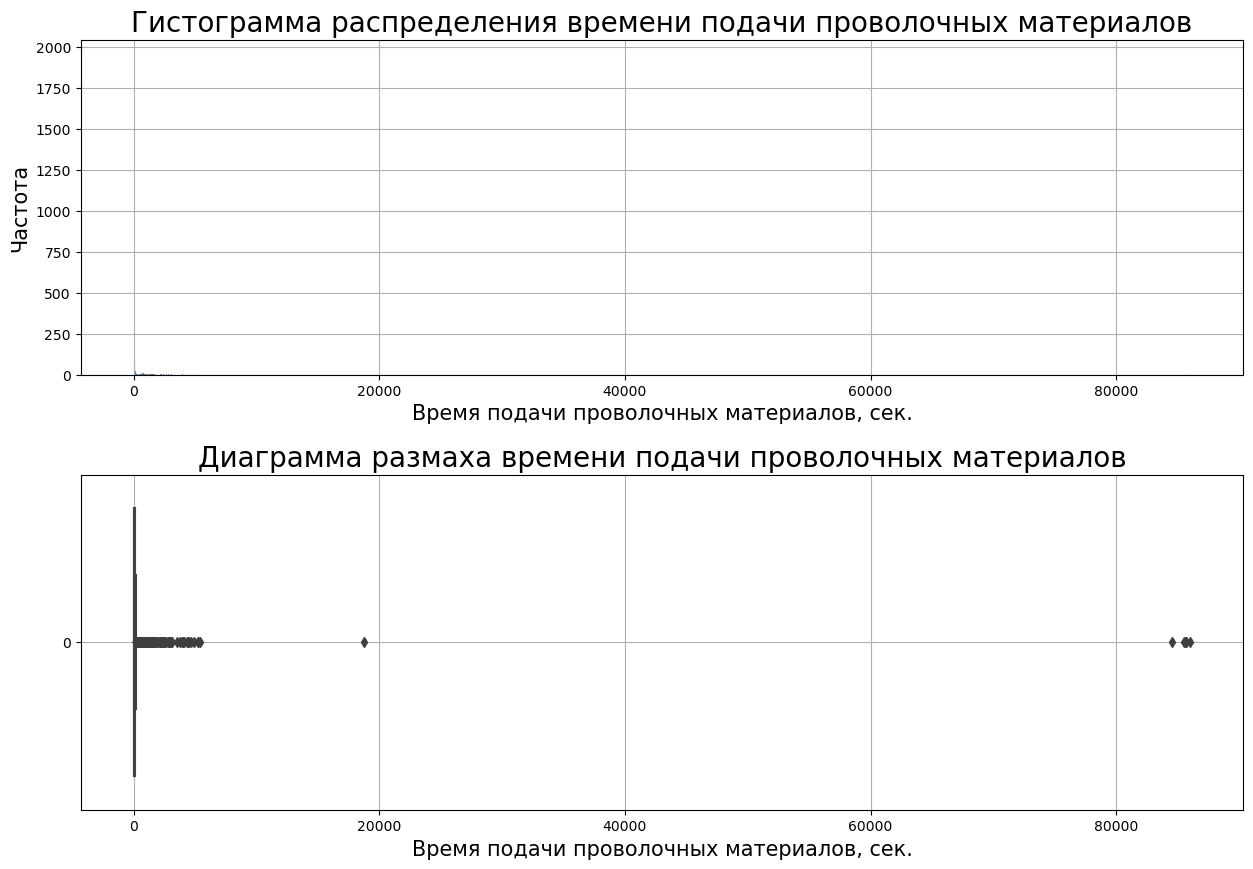

In [84]:
plt.figure()
plt.subplot(2,1,1)
sns.histplot(data=data_wire_time['duration_wire'])
plt.grid()
plt.xlabel('Время подачи проволочных материалов, сек.', fontsize=15)
plt.ylabel('Частота', fontsize=15)
plt.title('Гистограмма распределения времени подачи проволочных материалов', fontsize=20)

plt.subplot(2,1,2)
sns.boxplot(data=data_wire_time['duration_wire'], orient='horizontal')
plt.grid()
plt.xlabel('Время подачи проволочных материалов, сек.', fontsize=15)
plt.title('Диаграмма размаха времени подачи проволочных материалов', fontsize=20)

plt.subplots_adjust(hspace=0.3)

plt.show();

In [85]:
data_wire_time.query('duration_wire > 15000')

,key,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9,first_time_wire,last_time_wire,duration_wire
257,280,1900-01-01 23:40:41,1900-01-01 23:52:04,NaT,NaT,NaT,NaT,NaT,1900-01-01 00:03:32,NaT,1900-01-01 00:03:32,1900-01-01 23:52:04,85712
389,421,1900-01-01 23:58:24,1900-01-01 00:09:58,NaT,NaT,NaT,NaT,NaT,NaT,NaT,1900-01-01 00:09:58,1900-01-01 23:58:24,85706
701,745,1900-01-01 23:56:02,1900-01-01 00:01:56,NaT,NaT,NaT,NaT,NaT,NaT,NaT,1900-01-01 00:01:56,1900-01-01 23:56:02,86046
1224,1292,1900-01-01 23:40:54,1900-01-01 00:11:16,NaT,NaT,NaT,NaT,NaT,NaT,NaT,1900-01-01 00:11:16,1900-01-01 23:40:54,84578
1785,1875,1900-01-01 23:51:27,1900-01-01 00:05:38,NaT,NaT,NaT,NaT,NaT,NaT,NaT,1900-01-01 00:05:38,1900-01-01 23:51:27,85549
2011,2108,1900-01-01 19:50:47,NaT,1900-01-01 14:43:41,1900-01-01 14:40:29,NaT,1900-01-01 14:38:11,1900-01-01 19:46:16,NaT,NaT,1900-01-01 14:38:11,1900-01-01 19:50:47,18756
2591,2725,1900-01-01 23:52:07,NaT,NaT,NaT,NaT,1900-01-01 00:04:33,NaT,NaT,NaT,1900-01-01 00:04:33,1900-01-01 23:52:07,85654


У нас обнаружились результаты, имеющие высокие значения. Можно сделать вывод, что конечное время добавки материалов зафиксировано на следующие сутки относительно начального времени. Поэтому напишем функцию, которая добавит одни сутки ко времени окончания добавки проволочных материалов.

In [86]:
def increase_the_date(dataframe):
    mask = dataframe['duration_wire'] > 80000
    time_columns = dataframe.columns[1:10]
    one_hour = timedelta(hours=1)
    one_day = timedelta(days=1)

    for column in time_columns:
        dataframe.loc[(mask) & (dataframe[column].dt.time < datetime.time(hour=1)), column] += one_day

    return dataframe

In [87]:
data_wire_time = increase_the_date(data_wire_time)

data_wire_time.query('duration_wire > 15000')

,key,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9,first_time_wire,last_time_wire,duration_wire
257,280,1900-01-01 23:40:41,1900-01-01 23:52:04,NaT,NaT,NaT,NaT,NaT,1900-01-02 00:03:32,NaT,1900-01-01 00:03:32,1900-01-01 23:52:04,85712
389,421,1900-01-01 23:58:24,1900-01-02 00:09:58,NaT,NaT,NaT,NaT,NaT,NaT,NaT,1900-01-01 00:09:58,1900-01-01 23:58:24,85706
701,745,1900-01-01 23:56:02,1900-01-02 00:01:56,NaT,NaT,NaT,NaT,NaT,NaT,NaT,1900-01-01 00:01:56,1900-01-01 23:56:02,86046
1224,1292,1900-01-01 23:40:54,1900-01-02 00:11:16,NaT,NaT,NaT,NaT,NaT,NaT,NaT,1900-01-01 00:11:16,1900-01-01 23:40:54,84578
1785,1875,1900-01-01 23:51:27,1900-01-02 00:05:38,NaT,NaT,NaT,NaT,NaT,NaT,NaT,1900-01-01 00:05:38,1900-01-01 23:51:27,85549
2011,2108,1900-01-01 19:50:47,NaT,1900-01-01 14:43:41,1900-01-01 14:40:29,NaT,1900-01-01 14:38:11,1900-01-01 19:46:16,NaT,NaT,1900-01-01 14:38:11,1900-01-01 19:50:47,18756
2591,2725,1900-01-01 23:52:07,NaT,NaT,NaT,NaT,1900-01-02 00:04:33,NaT,NaT,NaT,1900-01-01 00:04:33,1900-01-01 23:52:07,85654


Чтобы корректно заполнить таблицу, заново заполним созданные ранее новые признаки корректными данными.

In [88]:
data_wire_time['first_time_wire'] = data_wire_time.iloc[:, 1:10].min(axis=1)
data_wire_time['last_time_wire'] = data_wire_time.iloc[:, 1:10].max(axis=1)
data_wire_time['duration_wire'] = (data_wire_time['last_time_wire'] - data_wire_time['first_time_wire']) // pd.Timedelta('1s')

In [89]:
data_wire_time['duration_wire'].describe()

count     3081.000000
mean       159.209348
std        563.710151
min          0.000000
25%          0.000000
50%          0.000000
75%         80.000000
max      18756.000000
Name: duration_wire, dtype: float64

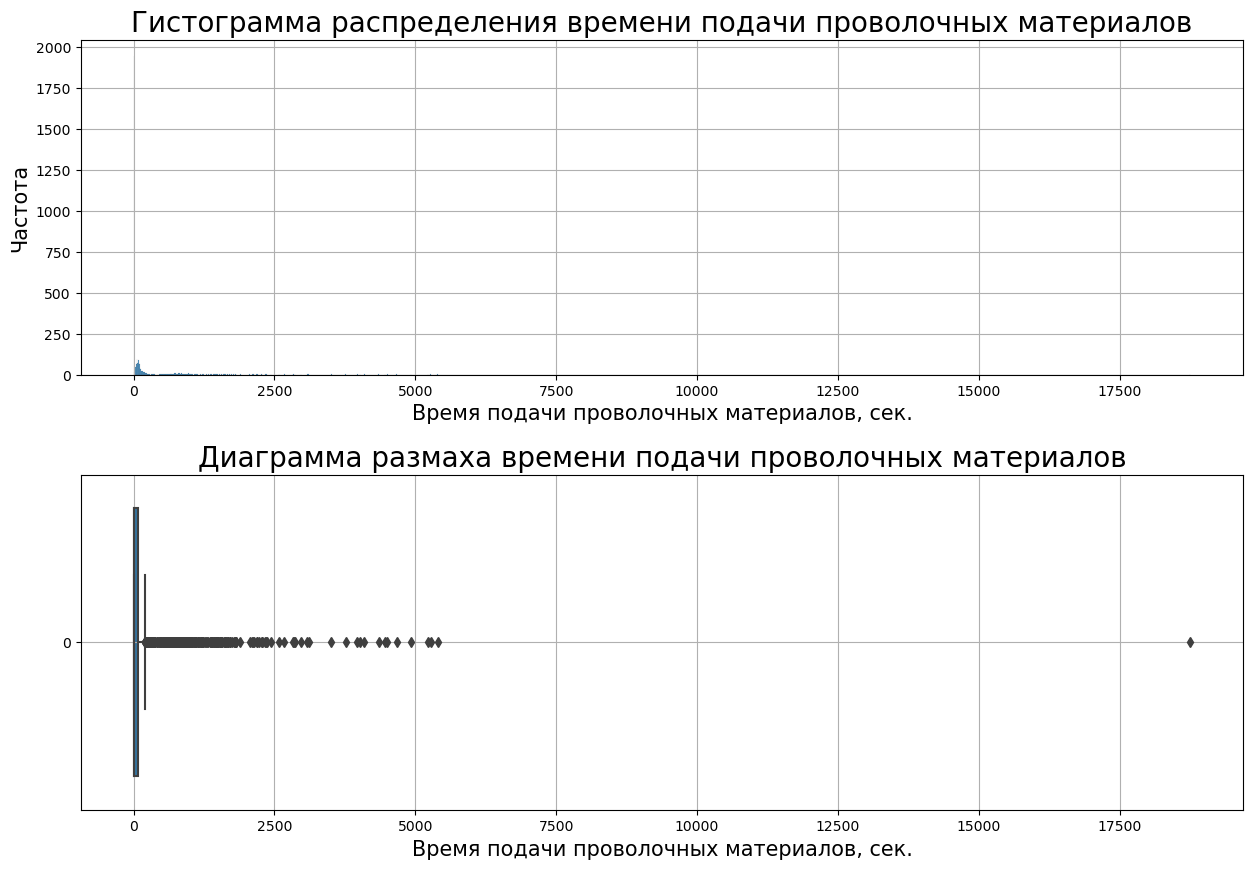

In [90]:
plt.figure()
plt.subplot(2,1,1)
sns.histplot(data=data_wire_time['duration_wire'])
plt.grid()
plt.xlabel('Время подачи проволочных материалов, сек.', fontsize=15)
plt.ylabel('Частота', fontsize=15)
plt.title('Гистограмма распределения времени подачи проволочных материалов', fontsize=20)

plt.subplot(2,1,2)
sns.boxplot(data=data_wire_time['duration_wire'], orient='horizontal')
plt.grid()
plt.xlabel('Время подачи проволочных материалов, сек.', fontsize=15)
plt.title('Диаграмма размаха времени подачи проволочных материалов', fontsize=20)

plt.subplots_adjust(hspace=0.3)

plt.show();

Несмотря на то, что в данных есть выбросы, аномалий не обнаружено.

Оставим в таблице только столбец с ключом и столбцы с новыми признаками.

In [91]:
data_wire_time = data_wire_time[['key', 'first_time_wire', 'last_time_wire','duration_wire']]

In [92]:
data_wire_time.head()

,key,first_time_wire,last_time_wire,duration_wire
0,1,1900-01-01 11:11:41,1900-01-01 11:11:41,0
1,2,1900-01-01 11:46:10,1900-01-01 11:46:10,0
2,3,1900-01-01 12:13:47,1900-01-01 12:13:47,0
3,4,1900-01-01 12:48:05,1900-01-01 12:48:05,0
4,5,1900-01-01 13:18:15,1900-01-01 13:32:06,831


In [93]:
data_wire_time.describe(include='all')

,key,first_time_wire,last_time_wire,duration_wire
count,3081.000000,3081,3081,3081.000000
unique,NaN,3026,3021,NaN
top,NaN,1900-01-01 17:52:31,1900-01-01 11:11:41,NaN
freq,NaN,2,2,NaN
first,NaN,1900-01-01 00:00:37,1900-01-01 00:00:51,NaN
last,NaN,1900-01-01 23:59:55,1900-01-02 00:11:16,NaN
mean,1623.426485,NaN,NaN,159.209348
std,932.996726,NaN,NaN,563.710151
min,1.000000,NaN,NaN,0.000000
25%,823.000000,NaN,NaN,0.000000


### Объединение таблиц

In [94]:
data = data_temp.merge(right=data_arc_group,
                       how='inner',
                       on='key')\
                .merge(right=data_bulk,
                       how='inner',
                       on='key')\
                .merge(right=data_bulk_time,
                       how='inner',
                       on='key')\
                .merge(right=data_gas,
                       how='inner',
                       on='key')\
                .merge(right=data_wire,
                       how='inner',
                       on='key')\
                .merge(right=data_wire_time,
                       how='inner',
                       on='key')

In [95]:
data = data.set_index('key')

In [96]:
data.head()

,start_temperature,finish_temperature,duration_time,key_counts,begin_heat,end_heat,active_power,reactive_power,total_power,res,...,wire_2,wire_3,wire_4,wire_6,wire_7,wire_8,wire_9,first_time_wire,last_time_wire,duration_wire
key,,,,,,,,,,,,,,,,,,,,,
1,1571.0,1613.0,861,5,1900-01-01 11:02:14,1900-01-01 11:28:37,0.975629,0.636648,1.165279,1098,...,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,1900-01-01 11:11:41,1900-01-01 11:11:41,0
2,1581.0,1602.0,1305,4,1900-01-01 11:34:14,1900-01-01 11:53:18,0.763150,0.499528,0.912304,811,...,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,1900-01-01 11:46:10,1900-01-01 11:46:10,0
3,1596.0,1599.0,1300,5,1900-01-01 12:06:54,1900-01-01 12:32:19,0.505176,0.319815,0.597907,655,...,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,1900-01-01 12:13:47,1900-01-01 12:13:47,0
4,1601.0,1625.0,388,4,1900-01-01 12:39:37,1900-01-01 12:57:50,0.802313,0.515074,0.953741,741,...,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,1900-01-01 12:48:05,1900-01-01 12:48:05,0
5,1576.0,1602.0,762,4,1900-01-01 13:11:13,1900-01-01 13:33:55,0.836793,0.563161,1.008939,869,...,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,1900-01-01 13:18:15,1900-01-01 13:32:06,831


In [97]:
data.shape

(2325, 41)

In [98]:
data = data.drop(data.select_dtypes('datetime').columns, axis=1)

In [99]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2325 entries, 1 to 2499
Data columns (total 35 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   start_temperature   2325 non-null   float64
 1   finish_temperature  2325 non-null   float64
 2   duration_time       2325 non-null   int64  
 3   key_counts          2325 non-null   int64  
 4   active_power        2325 non-null   float64
 5   reactive_power      2325 non-null   float64
 6   total_power         2325 non-null   float64
 7   res                 2325 non-null   int64  
 8   power_factor        2325 non-null   float64
 9   energy              2325 non-null   float64
 10  bulk_1              2325 non-null   float64
 11  bulk_2              2325 non-null   float64
 12  bulk_3              2325 non-null   float64
 13  bulk_4              2325 non-null   float64
 14  bulk_5              2325 non-null   float64
 15  bulk_6              2325 non-null   float64
 16  bulk_7

Построим тепловую карту матрицы корреляций

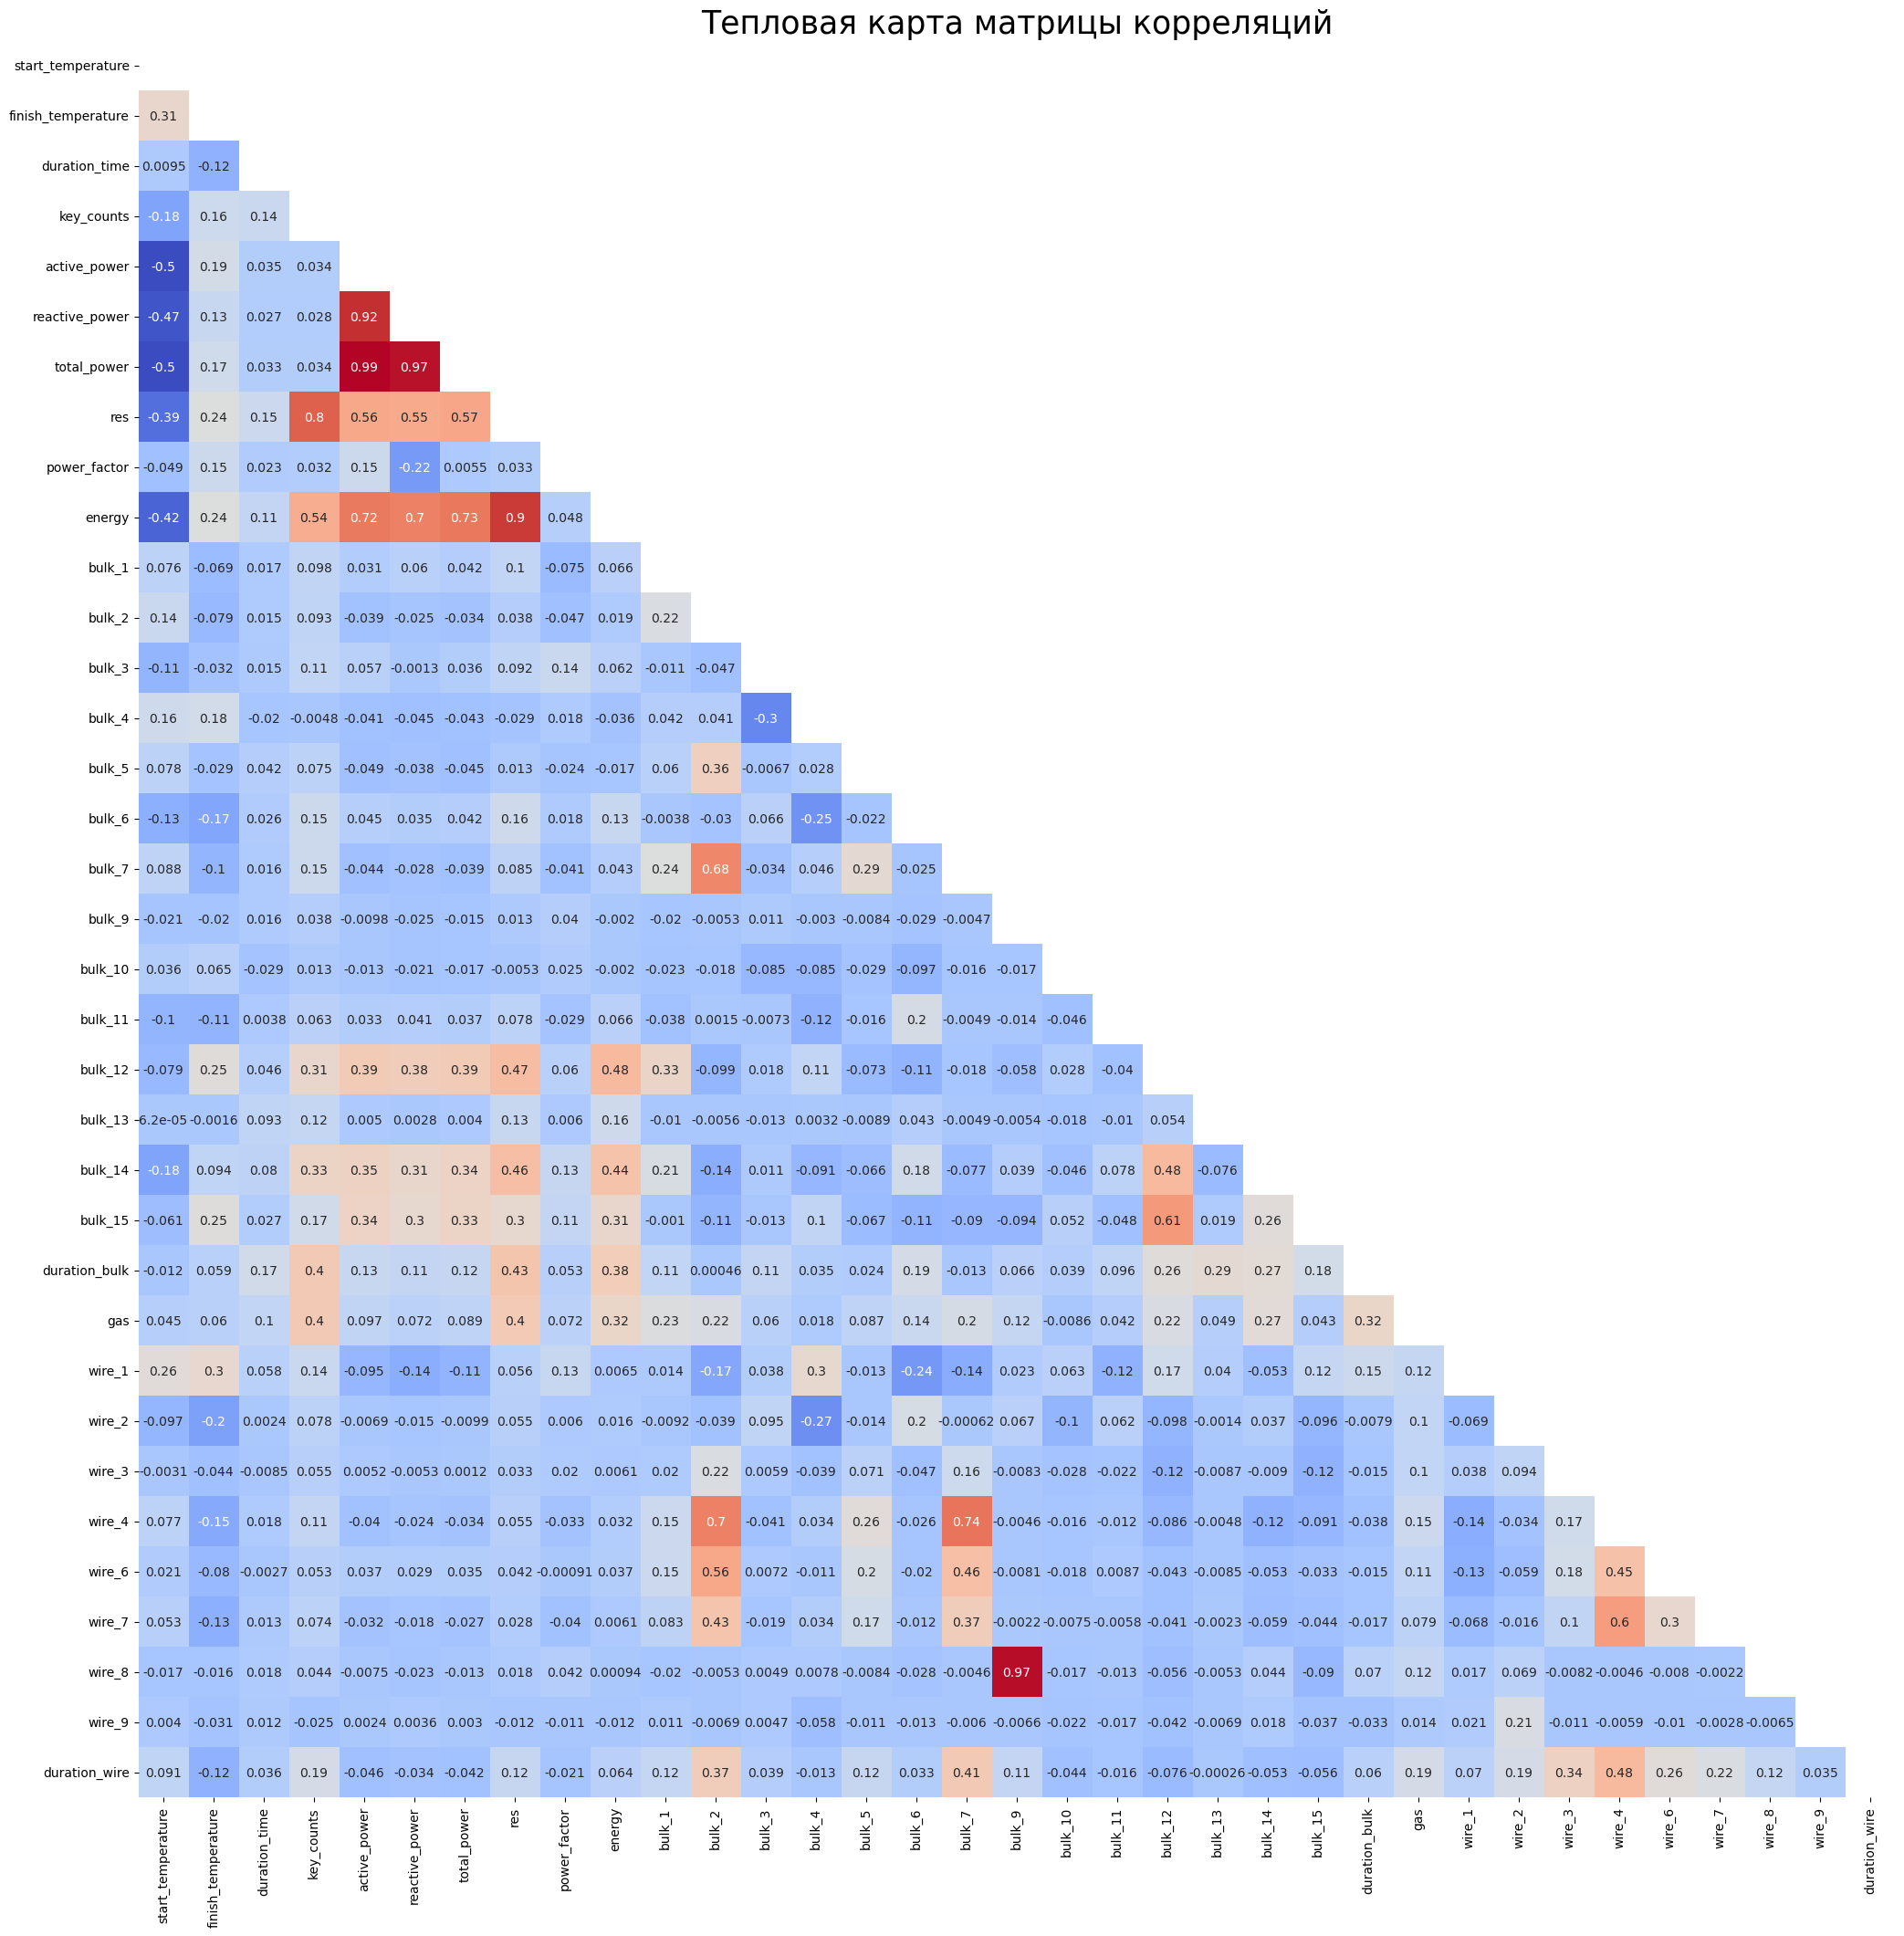

In [100]:
plt.figure(figsize=(25, 25))
matrix = np.triu(data.corr())
heatmap = sns.heatmap(data.corr(),
                      annot=True,
                      mask=matrix,
                      square=True,
                      cmap='coolwarm',
                      cbar=False,
                      fmt='.2g')
heatmap.set_title('Тепловая карта матрицы корреляций', fontsize=25);

In [101]:
data_corr=pd.Series()
for col in data.columns:
    data_corr[col] = data['finish_temperature'].corr(data[col])
data_corr= data_corr.sort_values(ascending=False)[1:]

Посморим корреляцию целевого признака с обучающими признаками.

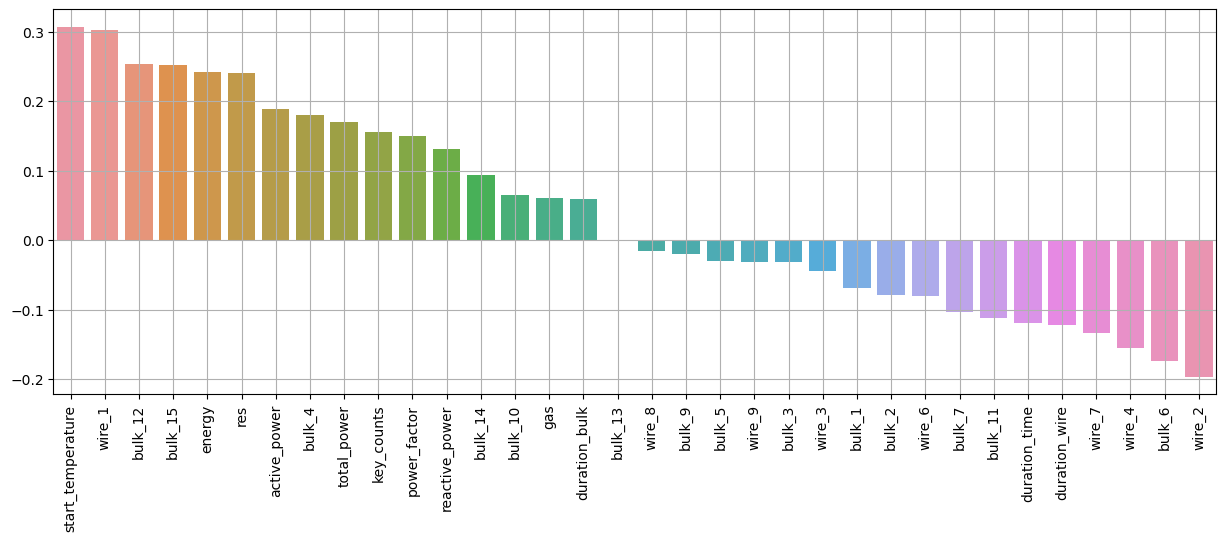

In [102]:
plt.figure(figsize=(15,5))
sns.barplot(x=data_corr.index, y=data_corr.values)
plt.grid()
plt.xticks(rotation=90)
plt.show()

### Разделение на выборки

In [103]:
features = data.drop('finish_temperature', axis=1)
target = data['finish_temperature']

In [104]:
print(features.shape)
print(target.shape)

(2325, 34)
(2325,)


In [105]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.25, random_state=RANDOM_STATE)

**Выводы**

1. Исследование и предобработка данных.
    - датафрейм `data_arc` содержит 14876 строк, пропусков и дубликатов нет. В таблице содержатся записи о 3214 партиях стали. Количество обработок одной партии составляет от 1 до 16 раз. Исправлена аномалия - отрицательное значение реактивной мощности. Добавлены новые признаки - разницу времени начала и конца нагрева электродов, полную мощность и коэффициент мощности. Для предстоящего объединения с другими таблицами, данные агрегировали по ключу;
    - датафрейм `data_bulk` содержит 3129 строк, 16 признаков, дубликатов нет, но много пропусков. Пропуски означают, что данный материал на этом этапе не засыпался. Материал, который только единожды засыпался, из таблицы удалили;
    - датафрейм `data_bulk_time` также содержит 3129 строк, не имеет дубликатов, но имеет много пропусков, которые совпадают с предыдущей таблицей, так как эти таблицы полностью взаимосвязаны. Были добавлены новые признаки - время засыпки первого материала, время засыпки последнего материала и общая длительность процесса засыпки. Затем удалили лишние признаки, оставив в таблице только новые признаки;
    - датафрейм `data_gas` содержит 3239 строк и 1 признак. Данные корректные, в обработке не нуждаются;
    - датафрейм `data_temp` содержит 15907 строк, в столбце "температура" 2901 пропуск. Для каждой партии оставили строки с первым и последним измерением температуры. Удалили строки со значением температуры ниже 1500 градусов. Создали новые признаки - столбцы с начальной и конечной температурой, а также столбец с временем между замерами температуры, получилась таблица с данными о 2471 партии;
    - датафрейм `data_wire` содержит 3081 строка, 10 признаков, дубликатов нет, но много пропусков. Пропуски означают, что данный материал на этом этапе не добавлялся. Материал, который добавлялся только единожды, из таблицы удалили;
    - датафрейм `data_wire_time` также содержит 3081 строк, не имеет дубликатов, но имеет много пропусков, которые совпадают с предыдущей таблицей, так как эти таблицы полностью взаимосвязаны. Были добавлены новые признаки - время добавки первого проволочного материала, время добавки последнего материала и общая длительность процесса добавки. Затем удалили лишние признаки, оставив в таблице только новые признаки.
1. Объединение таблиц.
    - все таблицы объединили в одну - `data`. Объединение сделали по ключу - столбцу `key`(номер партии) методом 'inner', то есть в таблицу вошли только те партии стали, данные о которой есть во всех таблицах. Получилась таблица с 2325 строками;
    - исключил из таблицы все признаки с типом 'datetime';
    - построили тепловую карту корреляции. Высокой корреляции целевого признака `finish_temperature` с остальными признаками нет, но между некоторыми признаками наблюдается высокая корреляция.
1. Разделение на выборки.
    - разделил данные на целевой признак `finish_temperature` и обучающие признаки, затем разделил данные на обучающую и тестовую выборки в соотношения 3:1.

## Обучение моделей

Масштабируем признаки

In [106]:
scaler = StandardScaler()
scaler.fit(X_train)

pd.options.mode.chained_assignment = None
X_train_scaled = scaler.transform(X_train)
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = scaler.transform(X_test)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

In [107]:
X_train_scaled.head()

,start_temperature,duration_time,key_counts,active_power,reactive_power,total_power,res,power_factor,energy,bulk_1,...,gas,wire_1,wire_2,wire_3,wire_4,wire_6,wire_7,wire_8,wire_9,duration_wire
0,2.402363,0.003512,0.183446,-0.955216,-0.844581,-0.931603,-0.523194,-0.265295,-0.814776,-0.279351,...,1.043512,5.132119,1.528044,-0.129198,-0.069192,-0.109592,-0.035756,-0.075871,-0.090248,1.593688
1,1.046531,-0.191069,0.803111,-1.110575,-1.161345,-1.151273,-0.217399,0.224593,-0.751378,-0.279351,...,-0.416738,0.553406,-0.536950,-0.129198,-0.069192,-0.109592,-0.035756,-0.075871,-0.090248,-0.252761
2,1.427859,-0.013236,0.183446,-0.988882,-0.634931,-0.871430,-0.332450,-0.678782,-0.453210,-0.279351,...,-0.013141,0.914800,-0.175868,-0.129198,-0.069192,-0.109592,-0.035756,-0.075871,-0.090248,2.571610
3,0.072026,-0.194664,-0.436219,-0.371128,-0.458281,-0.413944,-0.735131,0.361268,-0.702937,-0.279351,...,0.070930,0.587221,1.111273,-0.129198,-0.069192,-0.109592,-0.035756,-0.075871,-0.090248,-0.106901
4,0.283875,-0.199136,-0.436219,-1.022749,-0.828791,-0.970744,-0.686688,-0.673278,-0.859007,-0.279351,...,-1.131138,-0.742187,-0.536950,-0.129198,-0.069192,-0.109592,-0.035756,-0.075871,-0.090248,-0.252761


In [108]:
X_test_scaled.head()

,start_temperature,duration_time,key_counts,active_power,reactive_power,total_power,res,power_factor,energy,bulk_1,...,gas,wire_1,wire_2,wire_3,wire_4,wire_6,wire_7,wire_8,wire_9,duration_wire
0,2.021035,-0.039630,1.422777,-1.181117,-1.173170,-1.198482,0.227670,0.070518,-0.514574,-0.279351,...,0.807045,1.699934,0.957678,-0.129198,-0.069192,-0.109592,-0.035756,-0.075871,-0.090248,2.636252
1,-0.902478,-0.207642,-0.436219,-0.380541,-0.469657,-0.424651,-0.692744,0.315027,-0.743289,-0.279351,...,-0.343626,-0.970365,2.599613,-0.129198,-0.069192,-0.109592,-0.035756,-0.075871,-0.090248,-0.037286
2,-1.199067,-0.207905,0.803111,-0.687423,-1.197640,-0.872020,-0.108402,1.434088,-0.286408,-0.279351,...,-1.577171,-0.519151,0.359468,-0.129198,-0.069192,-0.109592,-0.035756,-0.075871,-0.090248,-0.145024
3,1.046531,-0.195628,-1.055884,-1.472996,-1.066499,-1.342229,-1.380026,-1.593663,-1.136814,-0.279351,...,-0.266938,-0.066881,-0.536950,-0.129198,-0.069192,-0.109592,-0.035756,-0.075871,-0.090248,-0.252761
4,1.385489,-0.172917,-1.055884,0.224734,0.112141,0.181330,-0.704854,0.496395,-0.444197,-0.279351,...,0.013558,0.198353,-0.536950,-0.129198,-0.069192,-0.109592,-0.035756,-0.075871,-0.090248,-0.252761


Для обучения выберем следующие модели:
- Lasso Regression
- Random Forest
- LightGBM
- XGBoost
- Нейронная сеть
    
Но в начале обучим константную модель для сравнительной оценки наших моделей.

Для оценки моделей используем метрику MAE.

### Константная модель

In [109]:
dummy_model = DummyRegressor(strategy='median')
dummy_model.fit(X_train_scaled, y_train)

DummyRegressor(strategy='median')

In [110]:
dummy_mae = mean_absolute_error(y_test, dummy_model.predict(X_test_scaled))
print("MAE Dummy Regressor: {:.2f}".format(dummy_mae))

MAE Dummy Regressor: 8.25


In [111]:
def random_search(model, hyperparams, n_iter=25, X_train=X_train, y_train=y_train):
    model_srch= RandomizedSearchCV(estimator=model, 
                                  param_distributions=hyperparams,
                                  n_iter=n_iter,
                                  cv=5, 
                                  scoring='neg_mean_absolute_error',
                                  random_state=RANDOM_STATE)
    model_srch.fit(X_train, y_train)

    print(f'Лучшие гиперпараметры модели: {model_srch.best_params_}')
    print(f'MAE лучшей модели: {round(abs(model_srch.best_score_), 2)}')
    return model_srch

### Модель Lasso Regression

In [112]:
lasso_hyperparams = {'alpha' : np.linspace(0, 1, 100)}

In [113]:
lasso = random_search(Lasso(random_state=RANDOM_STATE), lasso_hyperparams, n_iter=50, X_train=X_train_scaled, y_train=y_train)

Лучшие гиперпараметры модели: {'alpha': 0.16161616161616163}
MAE лучшей модели: 6.14


### Модель Случайный лес

In [114]:
rf_hyperparams = { 
    'n_estimators': [50, 60, 70],
    'max_depth' : [None] + [i for i in range(2, 7)]
}

In [115]:
rf = random_search(RandomForestRegressor(random_state=RANDOM_STATE, criterion='absolute_error'), 
                                            rf_hyperparams, n_iter=15, X_train=X_train_scaled, y_train=y_train)

Лучшие гиперпараметры модели: {'n_estimators': 70, 'max_depth': None}
MAE лучшей модели: 6.17


### Модель градиентного бустинга LightGBM

In [116]:
lgb_hyperparams = {'max_depth'        : range(1, 10, 1),
                   'subsample'        : np.arange(0.5, 1, 0.1),
                   'feature_fraction' : np.arange(0.5, 1, 0.1),
                   'reg_alpha'        : np.arange(0, 1, 0.05),
                   'reg_lambda'       : np.arange(0, 30, 5)}

In [117]:
lgb = random_search(LGBMRegressor(random_state=RANDOM_STATE, metric='mae'), lgb_hyperparams, n_iter=50, 
                                                                            X_train=X_train, y_train=y_train)

[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.8999999999999999, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8999999999999999
[LightGBM] [Warning] feature_fraction is set=0.8999999999999999, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8999999999999999
[LightGBM] [Warning] feature_fraction is set=0.8999999999999999, colsamp

### Модель градиентного бустинга XGBoost

In [118]:
params_xgb = {'n_estimators':[150, 200, 250],
               'learning_rate':[0.1, 0.01, 0.001],
               'max_depth':[4,5,6]}

In [119]:
xgb = random_search(XGBRegressor(random_state=RANDOM_STATE, metric='mae'), params_xgb, n_iter=50, 
                                                                            X_train=X_train, y_train=y_train)

[23:10:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "metric" } are not used.

[23:10:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "metric" } are not used.

[23:10:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "metric" } are not used.

[23:10:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "metric" } are not used.

[23:10:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "metric" } are not used.

[23:10:09] WARNING: 

### Нейронная сеть

Переведём выборки в тензоры.

In [120]:
X_train_nn = torch.FloatTensor(np.array(X_train_scaled))
y_train_nn = torch.FloatTensor(np.array(y_train))

Разделим тренироочную выборку на тренировочную и валидационную.

In [121]:
print(X_train_nn.shape)
print(y_train_nn.shape)

torch.Size([1743, 34])
torch.Size([1743])


Построим простую нейронную сеть с двумя скрытыми слоями, функции активации и количество нейронов в скрытых слоях подберём вручную.

In [122]:
class Net(nn.Module):
    def __init__(self, n_in_neurons, n_hidden_neurons_1, n_hidden_neurons_2, n_out_neurons):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(n_in_neurons, n_hidden_neurons_1)
        self.act1 = nn.ReLU()
        self.fc2 = nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2) 
        self.act2 = nn.ReLU()
        self.fc3 = nn.Linear(n_hidden_neurons_2, n_out_neurons)
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.act1(x)
        x = self.fc2(x)
        x = self.act2(x)
        x = self.fc3(x)
        return x

Для улучшения модели используем три версии оптимизатора Adam, для каждого подберём гиперпараметр `lr` и обучим нейросеть с каждым вариантом оптимайзера, чтобы найти наилучший и использовать его далее.

In [123]:
n_in_neurons = X_train_nn.shape[1]
n_hidden_neurons_1 = 64
n_hidden_neurons_2 = 32
n_out_neurons = 1

net = Net(n_in_neurons, n_hidden_neurons_1, n_hidden_neurons_2, n_out_neurons)

optimizers = [
    (torch.optim.Adam, 1e-3),
    (torch.optim.Adam, 1e-2)
]

Для ранней остановки обучения, когда потеря больше не улучшается после определённой эпохи, создадим класс, который назовём EarlyStopping, и ипользуем его при обучении нейросети.

In [124]:
class EarlyStopping:
    def __init__(self, patience=5, delta=0.1):
        self.patience = patience
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.delta = delta

    def __call__(self, score):
        if self.best_score is None:
            self.best_score = score
        elif self.best_score - score > self.delta:
            self.best_score = score
            # reset counter if validation loss improves
            self.counter = 0
        elif self.best_score - score < self.delta:
            self.counter += 1
            print(f"INFO: Early stopping counter {self.counter} of {self.patience}")
            if self.counter >= self.patience:
                print('INFO: Early stopping')
                self.early_stop = True

In [125]:
mae_optimizers = []

kf = KFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE)

for optimizer_class, lr in optimizers:
    optimizer = optimizer_class(net.parameters(), lr=lr)
    mae_optimizer = []

    for train_index, valid_index in kf.split(X_train_nn):
        X_train_fold, X_valid_fold = X_train_nn[train_index], X_train_nn[valid_index]
        y_train_fold, y_valid_fold = y_train_nn[train_index], y_train_nn[valid_index]

        dataset_train = torch.utils.data.TensorDataset(X_train_fold, y_train_fold)
        train_dataloader = DataLoader(dataset_train, batch_size=40, shuffle=True, num_workers=0)
        dataset_valid = torch.utils.data.TensorDataset(X_valid_fold, y_valid_fold)
        valid_dataloader = DataLoader(dataset_valid, batch_size=40, num_workers=0) 
        
        early_stopping = EarlyStopping(patience=5, delta=0.1)

        num_epochs = 50000
        for epoch in range(num_epochs):
            net.train()
            for batch in train_dataloader:
                data_train, temperature_train = batch
                optimizer.zero_grad()

                preds = net.forward(data_train).flatten()
                loss_value = torch.abs(preds - temperature_train).mean()
                loss_value.backward()
                optimizer.step()

            if epoch % 100 == 0:
                predicted_temp = []
                with torch.no_grad():
                    net.eval()
                    for batch in valid_dataloader:  
                        data_valid, temperature_valid = batch
                        valid_preds = net.forward(data_valid).flatten()
                        predicted_temp.append(valid_preds)

                    predicted_temp = torch.cat(predicted_temp).detach().numpy()
                    MAE = mean_absolute_error(y_valid_fold, predicted_temp)
                    early_stopping(MAE)  # проверяем объективность

                    if early_stopping.counter == 0:
                        best_mae = MAE
                        best_predicted_temp = predicted_temp
                    print(f"epoch:{epoch}, MAE valid: {MAE}")

                    if early_stopping.early_stop:
                        print()
                        print('Early Stopping!')
                        print()
                        print(optimizer)
                        print()
                        print(f'Best MAE valid {early_stopping.best_score}')
                        print('_' * 75)
                        print()
                        mae_optimizer.append(round(early_stopping.best_score, 2))
                        break
    
    mae_optimizers.append(round(np.mean(mae_optimizer), 2))

epoch:0, MAE valid: 1592.5985107421875
epoch:100, MAE valid: 43.53260040283203
epoch:200, MAE valid: 25.495710372924805
epoch:300, MAE valid: 21.544374465942383
epoch:400, MAE valid: 21.414852142333984
epoch:500, MAE valid: 19.099952697753906
INFO: Early stopping counter 1 of 5
epoch:600, MAE valid: 19.896745681762695
INFO: Early stopping counter 2 of 5
epoch:700, MAE valid: 19.37093734741211
INFO: Early stopping counter 3 of 5
epoch:800, MAE valid: 19.37340545654297
epoch:900, MAE valid: 18.266511917114258
INFO: Early stopping counter 1 of 5
epoch:1000, MAE valid: 18.327587127685547
INFO: Early stopping counter 2 of 5
epoch:1100, MAE valid: 18.469846725463867
INFO: Early stopping counter 3 of 5
epoch:1200, MAE valid: 18.17690658569336
epoch:1300, MAE valid: 17.46036720275879
INFO: Early stopping counter 1 of 5
epoch:1400, MAE valid: 17.657114028930664
epoch:1500, MAE valid: 17.277788162231445
epoch:1600, MAE valid: 17.035503387451172
INFO: Early stopping counter 1 of 5
epoch:1700, MAE

In [126]:
optimizers_mae = pd.DataFrame(data = mae_optimizers, index = ['Adam, lr: 0.001',
                                                              'Adam, lr: 0.01'], columns = ['MAE'])
display(optimizers_mae.sort_values(by='MAE'))

,MAE
"Adam, lr: 0.001",8.96
"Adam, lr: 0.01",10.79


Наилучшие показатели у оптимизатора Adam c lr 0.001. 

Добавим в класс Net методы регуляризации `dropout` и `BatchNorm`, попробуем применить их в различных сочетаниях и оставим наилучшую комбинацию.

In [127]:
class Net(nn.Module):
    def __init__(self, n_in_neurons, n_hidden_neurons_1, n_hidden_neurons_2, n_out_neurons, dropout_rate):
            super(Net, self).__init__()

            self.fc1 = nn.Linear(n_in_neurons, n_hidden_neurons_1)
            self.bn1 = nn.BatchNorm1d(n_hidden_neurons_1)
            self.act1 = nn.ReLU()
            self.dp2 = nn.Dropout(p=dropout_rate)
            self.fc2 = nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2)
            self.act2 = nn.ReLU()
            self.fc3 = nn.Linear(n_hidden_neurons_2, n_out_neurons)

    def forward(self, x):
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.act1(x)
        x = self.dp2(x)
        x = self.fc2(x)
        x = self.act2(x)
        x = self.fc3(x)

        return x

Подберём лучшие параметры «dropout» и «размер батча».

In [128]:
dropout_rates = [0.2, 0.5]
batch_sizes = [16, 32]

best_mae_so_far = None
best_hyperparameters_so_far = None
total_mae = 0
num_folds = 0

for dropout_rate in dropout_rates:
    for batch_size in batch_sizes:

        net = Net(n_in_neurons, n_hidden_neurons_1, n_hidden_neurons_2, n_out_neurons, dropout_rate)
        optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)

        for train_index, valid_index in kf.split(X_train_nn):
            X_train_fold, X_valid_fold = X_train_nn[train_index], X_train_nn[valid_index]
            y_train_fold, y_valid_fold = y_train_nn[train_index], y_train_nn[valid_index]

            dataset_train = torch.utils.data.TensorDataset(X_train_fold, y_train_fold)
            train_dataloader = DataLoader(dataset_train, batch_size=batch_size, shuffle=True, num_workers=0)
            dataset_valid = torch.utils.data.TensorDataset(X_valid_fold, y_valid_fold)
            valid_dataloader = DataLoader(dataset_valid, batch_size=batch_size, num_workers=0)

            train_dataloader = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
            valid_dataloader = DataLoader(dataset_valid, batch_size=batch_size, shuffle=False)

            early_stopping = EarlyStopping(patience=5, delta=0.1)

            num_epochs = 50000

            best_mae = float('inf')

            for epoch in range(num_epochs):
                net.train()

                for batch in train_dataloader:
                    data_train, temperature_train = batch
                    optimizer.zero_grad()

                    preds = net.forward(data_train).flatten()

                    loss_value = torch.abs(preds - temperature_train).mean()
                    loss_value.backward()
                    optimizer.step()

                if epoch % 100 == 0:
                    predicted_temp = []

                    with torch.no_grad():
                        net.eval()

                        for batch in valid_dataloader:
                            data_valid, temperature_valid = batch
                            valid_preds = net.forward(data_valid).flatten()
                            predicted_temp.append(valid_preds)

                        predicted_temp = torch.cat(predicted_temp).detach().numpy()
                        MAE = mean_absolute_error(y_valid_fold, predicted_temp)
                        early_stopping(MAE)

                        if early_stopping.counter == 0:
                            best_mae = MAE
                            best_predicted_temp = predicted_temp
                            best_hyperparameters = {'dropout_rate': dropout_rate, 'batch_size': batch_size}

                        print(f"dropout rate: {dropout_rate}, batch size: {batch_size}, epoch: {epoch}, MAE valid: {MAE}")

                        if early_stopping.early_stop:
                            print()
                            print('Early Stopping!')
                            print('Best MAE:', best_mae)
                            print('Best hyperparameters:', best_hyperparameters)
                            print()
                            break

                if early_stopping.early_stop:
                    break

            if best_mae != float('inf'):
                print('_' * 75)
                print()

            if best_mae < float('inf'):
                if best_mae_so_far is None or best_mae < best_mae_so_far:
                    best_mae_so_far = best_mae
                    best_hyperparameters_so_far = best_hyperparameters

                total_mae += best_mae
                num_folds += 1

if num_folds > 0:
    print()
    print('Average MAE and best hyperparameters:')
    print('Average MAE:', total_mae / num_folds)
    print('Best hyperparameters:', best_hyperparameters_so_far)

dropout rate: 0.2, batch size: 16, epoch: 0, MAE valid: 1585.2620849609375
dropout rate: 0.2, batch size: 16, epoch: 100, MAE valid: 29.713714599609375
dropout rate: 0.2, batch size: 16, epoch: 200, MAE valid: 14.83596134185791
INFO: Early stopping counter 1 of 5
dropout rate: 0.2, batch size: 16, epoch: 300, MAE valid: 14.800616264343262
dropout rate: 0.2, batch size: 16, epoch: 400, MAE valid: 10.236185073852539
INFO: Early stopping counter 1 of 5
dropout rate: 0.2, batch size: 16, epoch: 500, MAE valid: 14.845551490783691
INFO: Early stopping counter 2 of 5
dropout rate: 0.2, batch size: 16, epoch: 600, MAE valid: 19.959293365478516
INFO: Early stopping counter 3 of 5
dropout rate: 0.2, batch size: 16, epoch: 700, MAE valid: 10.2259521484375
INFO: Early stopping counter 4 of 5
dropout rate: 0.2, batch size: 16, epoch: 800, MAE valid: 13.918234825134277
dropout rate: 0.2, batch size: 16, epoch: 900, MAE valid: 7.4805803298950195
INFO: Early stopping counter 1 of 5
dropout rate: 0.2, 

Лучшей получилась комбинация 'dropout_rate' с гиперпараметром p=0.2 и 'batch_size' = 32.

Количество нейронов  в скрытых слоях оставим такое же, какое подобрали для базовой нейросети, добавим в нейросеть наш наилучший оптимизатор, лучшие параметр «dropout» и «размер батча» и запустим нейросеть.

In [129]:
n_in_neurons = X_train_nn.shape[1]
n_hidden_neurons_1 = 64
n_hidden_neurons_2 = 32
dropout_rate = 0.2
batch_size = 32

net = Net(n_in_neurons, n_hidden_neurons_1, n_hidden_neurons_2, n_out_neurons, dropout_rate)
optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)
loss = nn.L1Loss()

Обучаем нейросеть.

In [130]:
val_loss = []
train_loss = []

for train_index, valid_index in kf.split(X_train_nn):
    X_train_fold, X_valid_fold = X_train_nn[train_index], X_train_nn[valid_index]
    y_train_fold, y_valid_fold = y_train_nn[train_index], y_train_nn[valid_index]

    dataset_train = torch.utils.data.TensorDataset(X_train_fold, y_train_fold)
    train_dataloader = DataLoader(dataset_train, batch_size=40, shuffle=True, num_workers=0)
    dataset_valid = torch.utils.data.TensorDataset(X_valid_fold, y_valid_fold)
    valid_dataloader = DataLoader(dataset_valid, batch_size=40, num_workers=0)

    early_stopping = EarlyStopping(patience=5, delta=0.1)

    num_epochs = 50000

    best_mae = float('inf')

    for epoch in range(num_epochs):
        net.train()
        train_loss_batches = []

        for batch in train_dataloader:
            data_train, temperature_train = batch
            optimizer.zero_grad()

            preds = net.forward(data_train).flatten()

            loss_value = torch.abs(preds - temperature_train).mean()

            loss_value.backward()
            optimizer.step()

            loss_value = loss_value.detach().numpy().reshape([-1])
            train_loss_batches.append(loss_value)

        if epoch % 100 == 0:
            predicted_temp = []
            with torch.no_grad():
                net.eval()
                for batch in valid_dataloader:
                    data_valid, temperature_valid = batch

                    valid_preds = net.forward(data_valid).flatten()
                    predicted_temp.append(valid_preds)

            predicted_temp = torch.cat(predicted_temp).detach().numpy()
            MAE = mean_absolute_error(y_valid_fold, predicted_temp)

            early_stopping(MAE)
            if early_stopping.counter == 0:
                best_mae = MAE
                best_predicted_temp = predicted_temp
            print(f"epoch:{epoch}, MAE valid: {MAE}")

            if early_stopping.early_stop:
                print()
                print('Early Stopping!')
                print()
                print(f'Best MAE valid {best_mae}')
                print('_' * 75)
                break

    val_loss.append(best_mae)
    train_loss.append(np.mean(train_loss_batches))
    mean_mae = np.mean(val_loss)

print('Average validation MAE:', mean_mae)

torch.save(net.state_dict(), "best_model.pt")

epoch:0, MAE valid: 1591.5849609375
epoch:100, MAE valid: 51.413185119628906
epoch:200, MAE valid: 44.23881530761719
epoch:300, MAE valid: 24.849586486816406
epoch:400, MAE valid: 20.74889373779297
epoch:500, MAE valid: 19.881141662597656
epoch:600, MAE valid: 13.368349075317383
epoch:700, MAE valid: 10.673784255981445
INFO: Early stopping counter 1 of 5
epoch:800, MAE valid: 12.578242301940918
epoch:900, MAE valid: 10.497138023376465
epoch:1000, MAE valid: 7.128413677215576
INFO: Early stopping counter 1 of 5
epoch:1100, MAE valid: 7.591840744018555
INFO: Early stopping counter 2 of 5
epoch:1200, MAE valid: 10.3604154586792
INFO: Early stopping counter 3 of 5
epoch:1300, MAE valid: 11.075508117675781
INFO: Early stopping counter 4 of 5
epoch:1400, MAE valid: 14.515525817871094
INFO: Early stopping counter 5 of 5
INFO: Early stopping
epoch:1500, MAE valid: 14.370165824890137

Early Stopping!

Best MAE valid 7.128413677215576
_____________________________________________________________

In [132]:
data_mae = pd.DataFrame( 
    index = ['Dummy-модель', 
             'Lasso Regression', 
             'Random Forest', 
             'LightGBM', 
             'XGBoost', 
             'Neural Network'],
    
    data = {'MAE':
            [round(abs(dummy_mae), 2), 
             round(abs(lasso.best_score_), 2), 
             round(abs(rf.best_score_), 2), 
             round(abs(lgb.best_score_), 2), 
             round(abs(xgb.best_score_), 2), 
             round(abs(mean_mae), 2)]})
data_mae

,MAE
Dummy-модель,8.25
Lasso Regression,6.14
Random Forest,6.17
LightGBM,5.86
XGBoost,5.97
Neural Network,6.35


Результаты обучения моделей свели в общую таблицу.

Лучшую метрику MAE на тренировочных данных показала модель LightGBM. MAE - 5.86.

Для проверки на тестовых данных выбираем эту модель.

## Тестирование лучшей модели.

Получим предсказание модели LightGBM с подобранными гиперпараметрами на тестовых данных.

In [133]:
model_test = LGBMRegressor(random_state=RANDOM_STATE, **lgb.best_params_)
model_test.fit(X_train, y_train)
predicted_test = model_test.predict(X_test)
result = round(mean_absolute_error(y_test, predicted_test), 2)
print('MAE на тестовых данных:', result)

MAE на тестовых данных: 6.23


Значение метрики MAE модели LightGBM, полученное на тестовых данных, - 6.23, это меньше максимальнго допустимого значения метрики 6.8, а также меньше результата константной модели, у которой MAE - 8.25. Это доказывает, что наша модель адекватна и может использоваться для нужд заказчика.

Построим таблицу и график важности признаков.

In [134]:
model = LGBMRegressor(random_state=RANDOM_STATE)

In [135]:
model.fit(X_train, y_train)

feature_names = X_train.columns
feature_importances = model.feature_importances_

zipped = zip(feature_names, feature_importances)
coefs = pd.DataFrame(zipped, columns=['Признаки', 'Коэффициент'])
coefs = coefs.sort_values('Коэффициент', ascending=False)

coefs

,Признаки,Коэффициент
0,start_temperature,337
1,duration_time,251
6,res,219
25,wire_1,214
8,energy,210
7,power_factor,203
24,gas,183
21,bulk_14,183
3,active_power,145
19,bulk_12,135


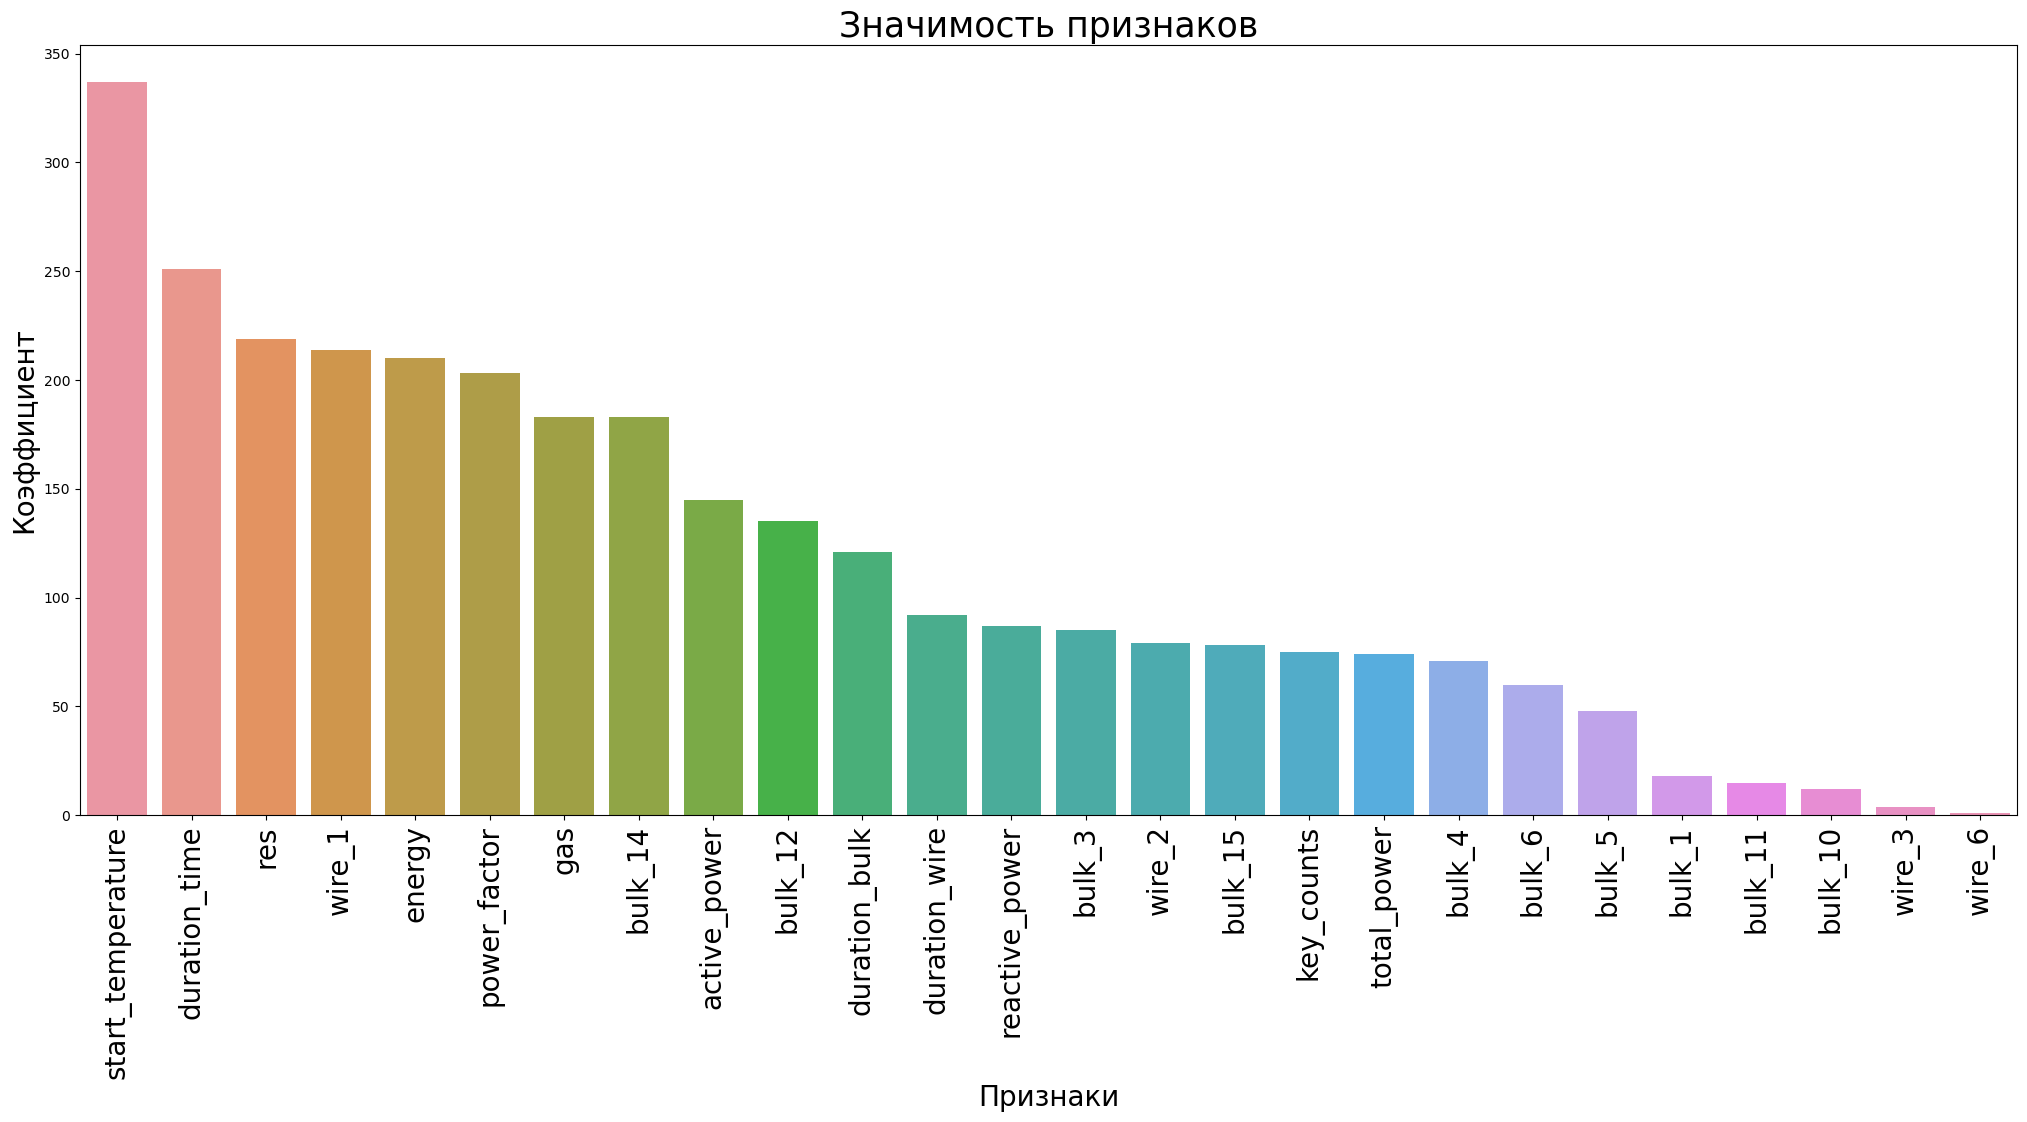

In [136]:
fig, ax = plt.subplots(1, 1, figsize=(25, 10))
sns.barplot(x='Признаки',
            y='Коэффициент',
            data=coefs.head(26)) 
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=20)
ax.set_title('Значимость признаков', fontsize=25)
ax.set_ylabel('Коэффициент', fontsize=20)
ax.set_xlabel('Признаки', fontsize=20);

Наиболее важными признаками для модели оказались - начальная температура, время между замером температуры, время нагрева электродов, объёма проволочного матерала 'wire_1', количества затраченной энергии, коэффициента мощности, объёма инертного газа и объёма сыпучего материала 'bulk_14'.

Рассмотрим зависимость целевого признака `finish_temperature` и одного изивходных признаков - `start_temperature`

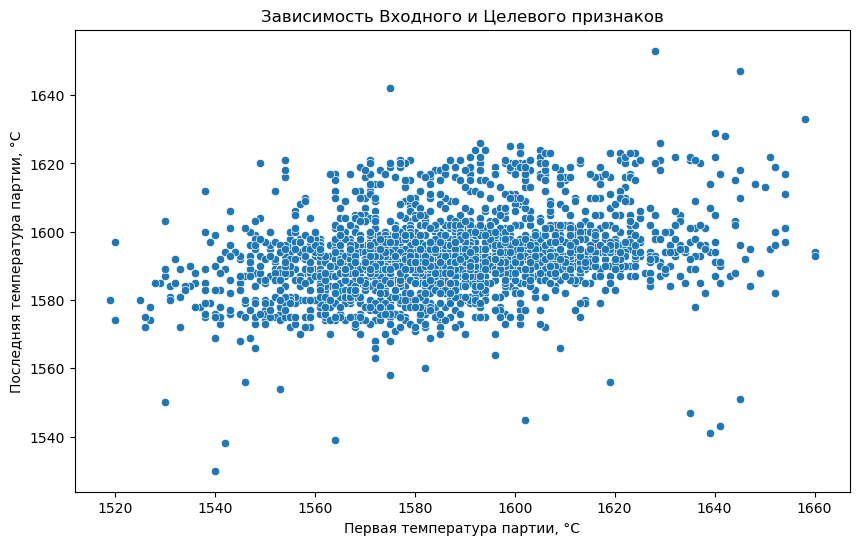

In [137]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='start_temperature', y='finish_temperature', data=data)
plt.title('Зависимость Входного и Целевого признаков')
plt.xlabel('Первая температура партии, °C')
plt.ylabel('Последняя температура партии, °C')
plt.show()

Несмотря на некоторый разброс значений, прослеживается зависимость - чем выше была начальная температура, тем выше конечная температура.

## Общий вывод.

Перед нами была поставлена задача - разработать модель, которая предскажет температуру сплава, что способствует уменьшению потребления энергии на этапе обработки стали.

Нам были предоставлены данные - семь таблиц с данными, которые фиксировались при обработке стали. 

Каждая таблица была изучена и предобработана. Обрабатывались пропуски и аномалии, создавались новые признаки, удалялись ненужные, удалялись строки с неполными данными. В результате все таблицы были сведены в одну. Получилась таблица с 2325 строками и 35 признаками. Данные были разделены на целевой признак `finish_temperature` - последняя температура партии, и обучающие признаки. Разделили данные на тренировочную и тестовую выборки.

Для обучения были выбраны пять моделей - Lasso Regression, Random Forest, LightGBM, XGBoost, Полносвязная нейронная сеть. Для каждой модели были подобраны гиперпараметры с помощью RandomizedSearchCV, модели были обучены и получены предсказания. 

Все модели показали допустимую метрику MAE - от 5.86 до 6.17. Лучшую метрику показала модель LightGBM - MAE 5.86. Она была выбрана для тестирования.

Модель была успешна протестирована - получены предсказания на тестовых данных, MAE составила 6.23, что меньше максимально допустимой 6.8.

Для улучшения модели можно рассмотреть подбор других гиперпараметров, более углублённо поработать с признаками - какие-то возможно удалить, а также сгенерировать новые признаки.

Заказчику можно посоветовать более точно собирать данные, чтобы исключить выбросы и улучшить статистику. Возможно добавить для исследования ещё какие-то данные, которые до сих пор не учитывались.

В целом можно заключить, что проделанная нами работа достигла поставлееных задач. Модель может эффективно использоваться заказчиком для уменьшения электропотребления.